In [62]:
library(dplyr)
library(ggplot2)
library(data.table)

setwd("/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM")

source("/mnt/lareaulab/reliscu/code/ggplot_theme.R")

source("/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/code/top_corr_module_fxns.R")

theme_set(default_theme())
options(repr.matrix.max.cols=Inf) 

Goal: verify enriched modules actually represent a given cell type by plotting cell type abundance vs. the module eigengene

In [63]:
# These should match the settings used to get enrichment results in previous step
mod_def <- "PosFDR"
unique <- FALSE
lfc_threshold <- 5

In [64]:
cell_meta <- fread("/mnt/lareaulab/reliscu/projects/NSF_GRFP/data/scRNA-seq/tasic_2018/ALM/tasic_2018_ALM_STAR_sampleinfo.csv", data.table=FALSE)
cell_meta$cell_subclass <- gsub(" ", "_", cell_meta$cell_subclass)
cell_meta$cell_subclass <- gsub("-", "_", cell_meta$cell_subclass)
cell_meta$cell_subclass <- gsub("/", "_", cell_meta$cell_subclass, fixed=TRUE)

In [65]:
sort(table(cell_meta$cell_subclass))


        L4       Peri         CR      Meis2        SMC       VLMC   Serpinf1 
         3          4         11         11         55         72         78 
Macrophage       Endo      Oligo        L6b       Sncg      Astro    L2_3_IT 
        85         96         98        145        148        215        325 
     L6_CT      L5_PT      L6_IT         NP      Pvalb      Lamp5        Sst 
       350        368        394        542        896        913       1139 
       Vip      L5_IT 
      1224       2401 

In [66]:
pairwise_res_list <- readRDS("data/tasic_2018_ALM_STAR_donor_cell_type_pseudobulk_pairwise_DE_genes_dream.RDS")
pairwise_ctype_genes <- prep_DE_genes(pooled_res_list, lfc_threshold, pairwise=TRUE, unique=unique)

# Round 1 (30% var network; PosBC module definiton)

In [22]:
network_dir <- "tasic_2018_ALM_STAR_20pcntCells_30pcntVar_200samples_log2_pseudobulk_Modules"

pseudobulk_legend <- read.csv("data/SyntheticDatasets/SyntheticDataset1_20pcntCells_30pcntVar_200samples_legend_10-04-30.csv")
pseudobulk_legend$Cell.type <- gsub("/", "_", pseudobulk_legend$Cell.type, fixed=TRUE)
pseudobulk_legend$Cell.type <- gsub(" ", "_", pseudobulk_legend$Cell.type)

# top_qval_mods_df <- read.csv("data/tasic_2018_ALM_STAR_donor_cell_type_pseudobulk_DE_genes_dream_unique_20pcntCells_30pcntVar_200samples_log2_pseudobulk_PosBC_top_Qval_modules.csv")
top_qval_mods_df <- read.csv("data/tasic_2018_ALM_STAR_donor_cell_type_pseudobulk_1_vs_pooled_DE_genes_dream_unique_20pcntCells_30pcntVar_200samples_log2_pseudobulk_PosBC_top_Qval_modules.csv")

In [ ]:
top_corr_mods_30pcnt_PosBC_df <- get_top_corr_mods(network_dir, pseudobulk_legend, top_qval_mods_df, ctype_genes_list, mod_def)
top_corr_mods_30pcnt_PosBC_df

,Cell_type,Pseudobulk_SD,Cor,Old_cor,Pval,Old_pval,Module_genes,Old_module_genes,Module,Old_module,Network,Old_network,ME_path,Old_ME_path,kME_path,Old_kME_path
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
cornsilk,L4,0.80,0.2522957,0.04998815,1.000000e+00,6.816074e-04,"Igfbp6, Wnt10a, Pkig, Ppp1r1a, Acvr1c, Kctd1, Sertad1, Mapk4, Frzb, Gm30092","Tafa2, Gpr176, Pacsin2, Mybpc1, Fam131c, Macrod1, Ptpre, Cenpa, Coq7, Pde5a",cornsilk,plum,Bicor-None_signum0.361_minSize4_merge_ME_0.9_20151,Bicor-None_signum0.361_minSize6_merge_ME_0.9_20151,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_30pcntVar_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.361_minSize4_merge_ME_0.9_20151/Module_eigengenes_11-01-11.csv,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_30pcntVar_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.361_minSize6_merge_ME_0.9_20151/Module_eigengenes_11-39-33.csv,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_30pcntVar_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.361_minSize4_merge_ME_0.9_20151/kME_table_11-01-11.csv,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_30pcntVar_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.361_minSize6_merge_ME_0.9_20151/kME_table_11-39-33.csv
rosybrown,CR,0.81,0.2529616,0.23783949,1.000000e+00,6.839027e-08,"Sgk1, Btg1, Lbh, Plxdc2, Pacs2, Kat2b, Dock10, Prkd3, Ybx1, Derl1","Gm26903, Bmp5, Gm28876, Gcgr, Dach1, Ripk4, Lhx9, NA, NA, NA",rosybrown,peachpuff,Bicor-None_signum0.214_minSize5_merge_ME_0.9_20151,Bicor-None_signum0.214_minSize5_merge_ME_0.9_20151,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_30pcntVar_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.214_minSize5_merge_ME_0.9_20151/Module_eigengenes_02-10-31.csv,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_30pcntVar_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.214_minSize5_merge_ME_0.9_20151/Module_eigengenes_02-10-31.csv,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_30pcntVar_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.214_minSize5_merge_ME_0.9_20151/kME_table_02-10-31.csv,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_30pcntVar_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.214_minSize5_merge_ME_0.9_20151/kME_table_02-10-31.csv
palegoldenrod,Serpinf1,3.20,0.2534290,0.10427283,1.000000e+00,1.581899e-04,"Crispld2, Sec14l1, Smoc1, Sorcs2, Hrh2, Ccn3, Dusp4, Prok2, NA, NA","Dlx6os1, Zfp536, Gm56079, Tcf4, Gm56080, Dlx1as, Slc2a13, Dlx1, Rgs10, Sema3c",palegoldenrod,tan,Bicor-None_signum0.214_minSize5_merge_ME_0.9_20151,Bicor-None_signum0.627_minSize8_merge_ME_0.9_20151,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_30pcntVar_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.214_minSize5_merge_ME_0.9_20151/Module_eigengenes_02-10-31.csv,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_30pcntVar_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.627_minSize8_merge_ME_0.9_20151/Module_eigengenes_10-58-46.csv,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_30pcntVar_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.214_minSize5_merge_ME_0.9_20151/kME_table_02-10-31.csv,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/m

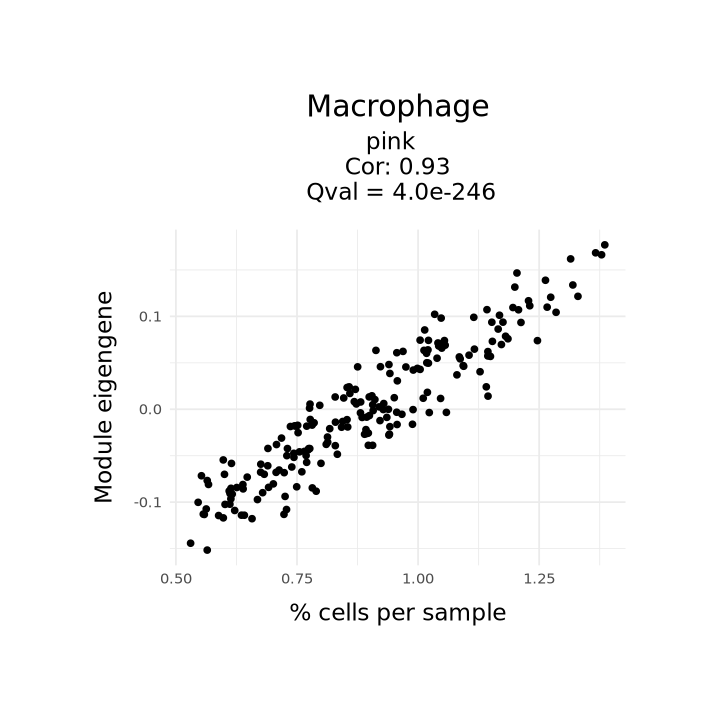

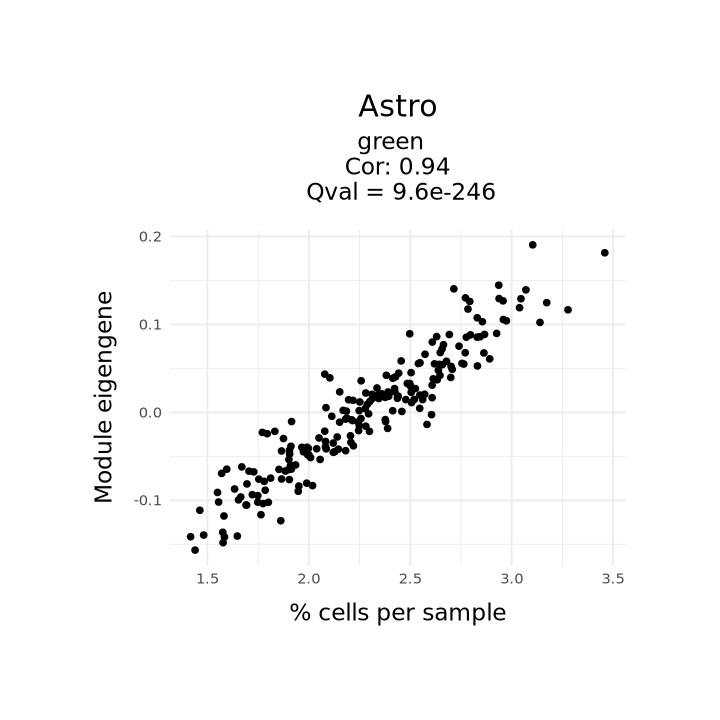

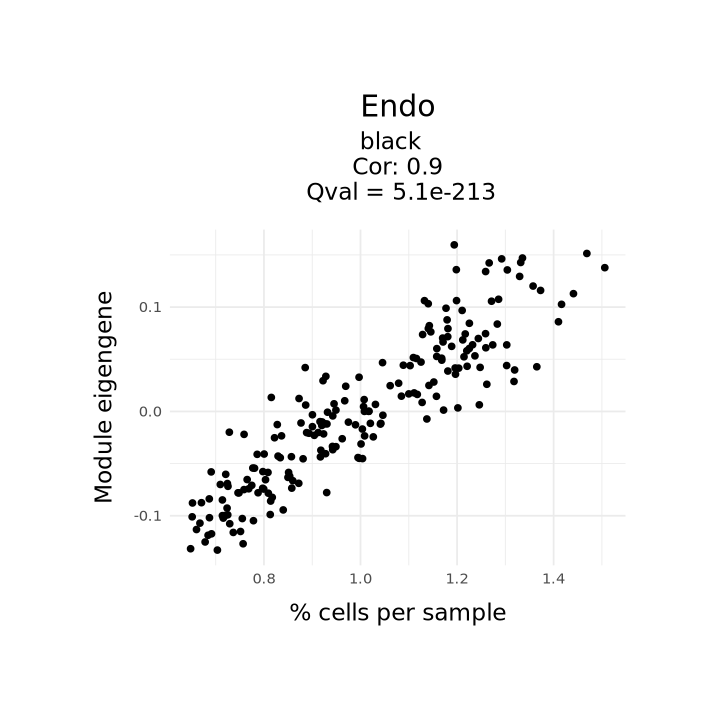

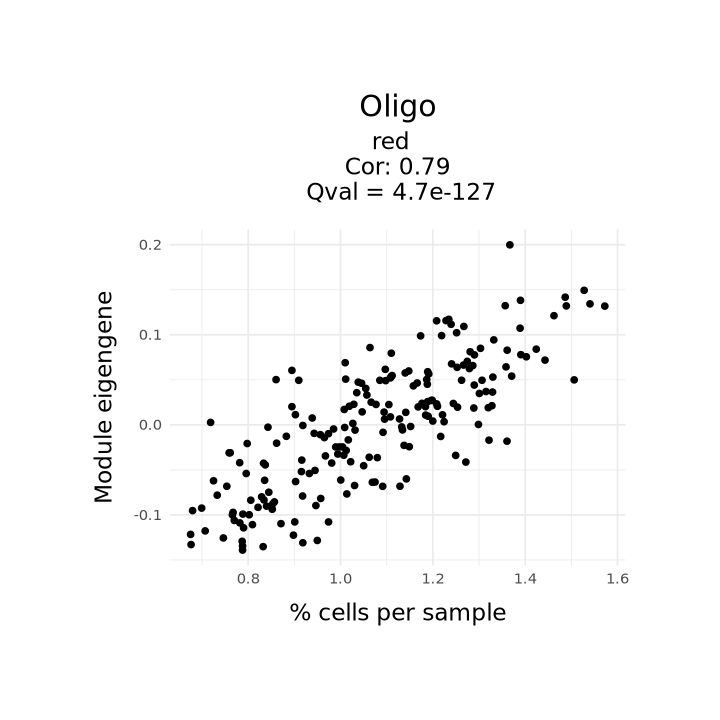

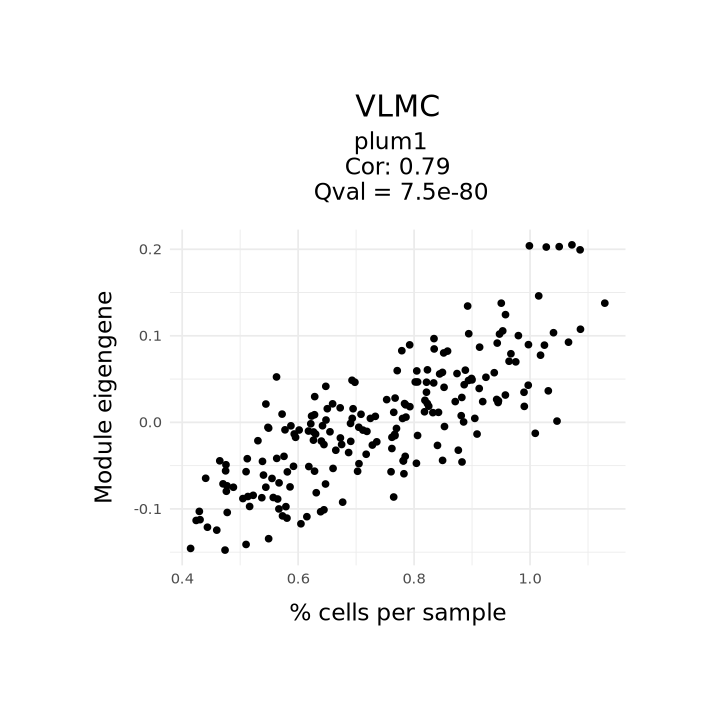

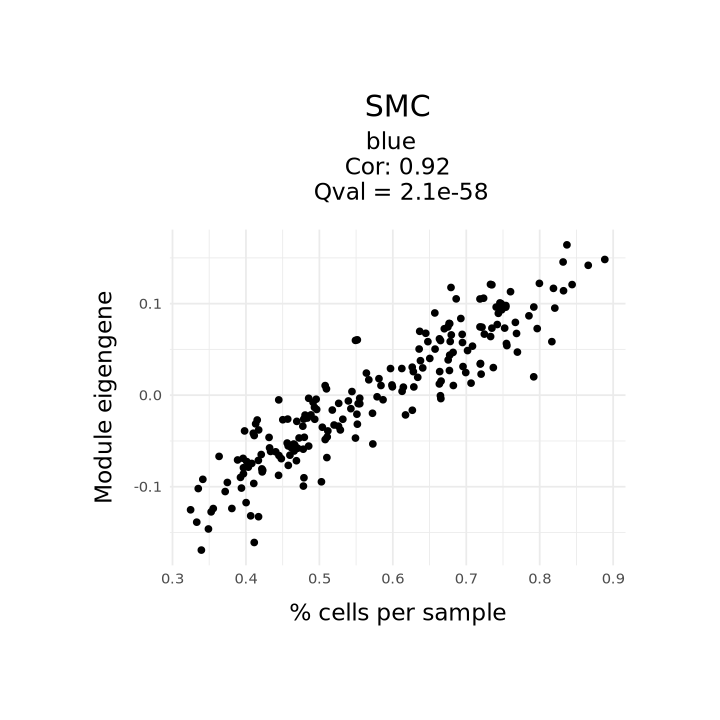

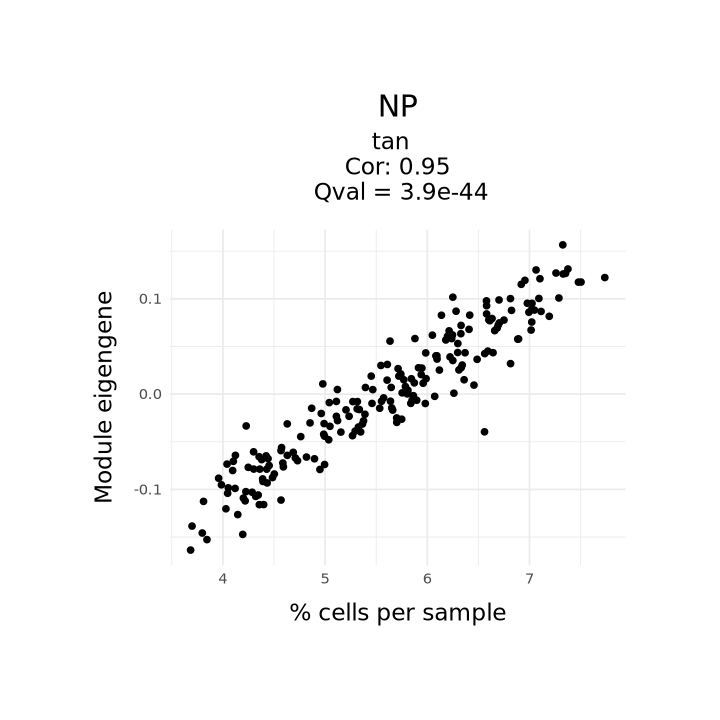

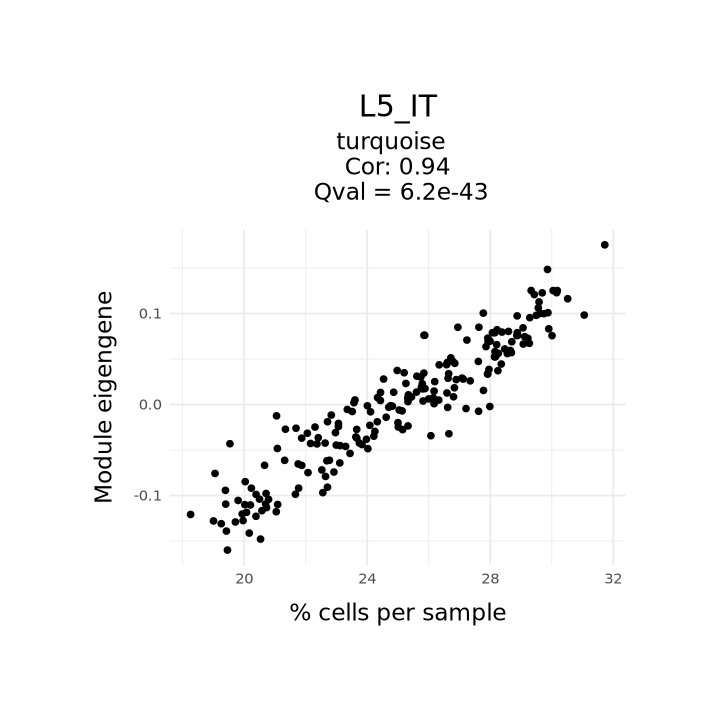

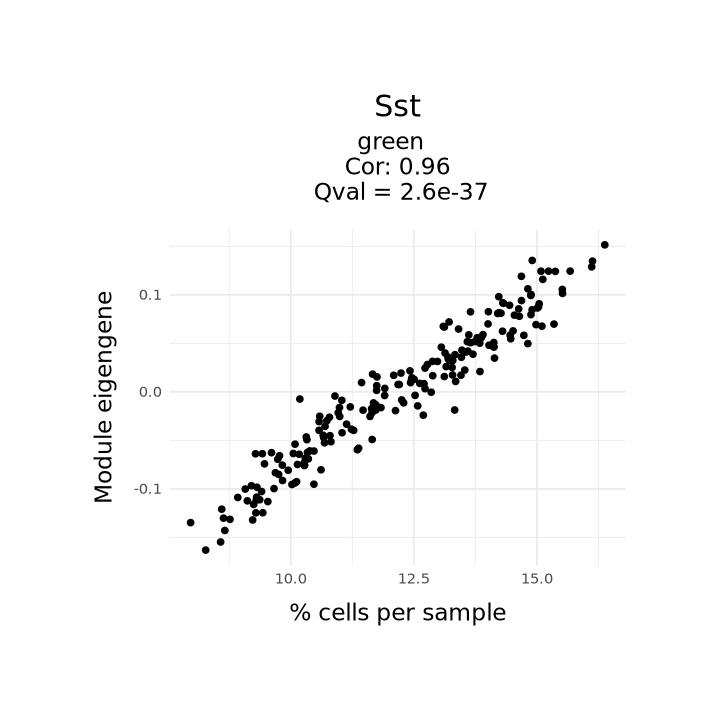

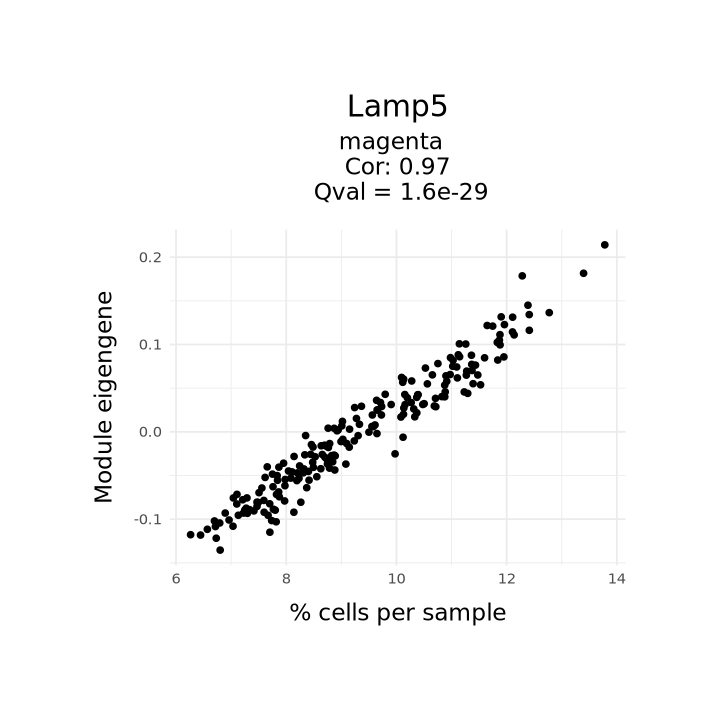

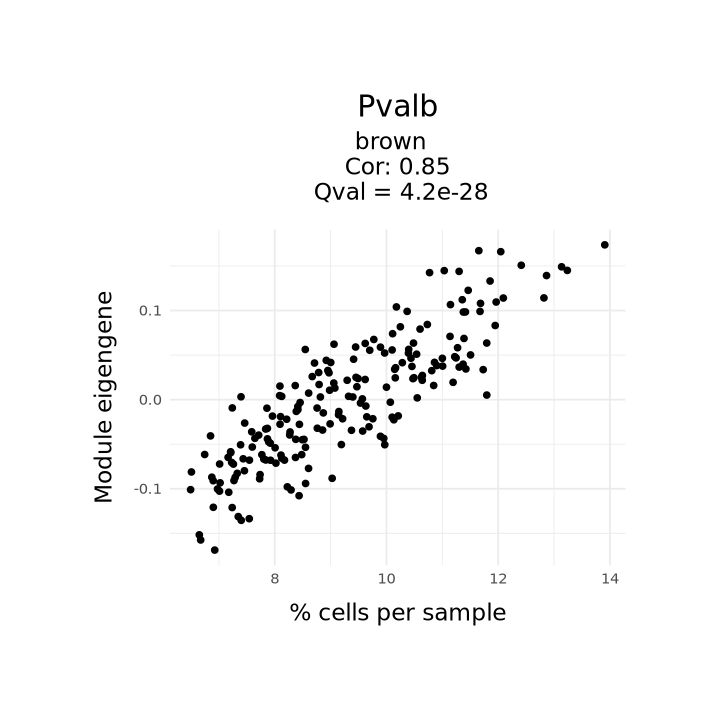

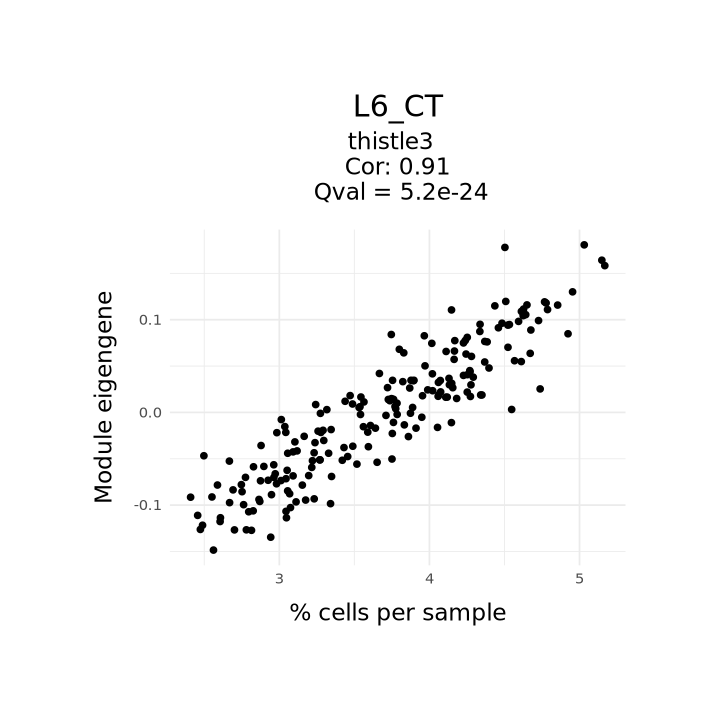

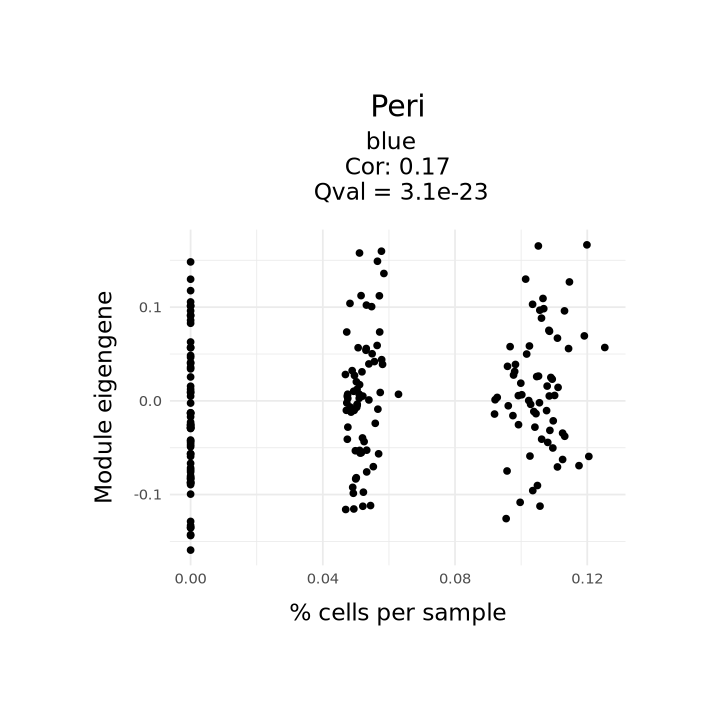

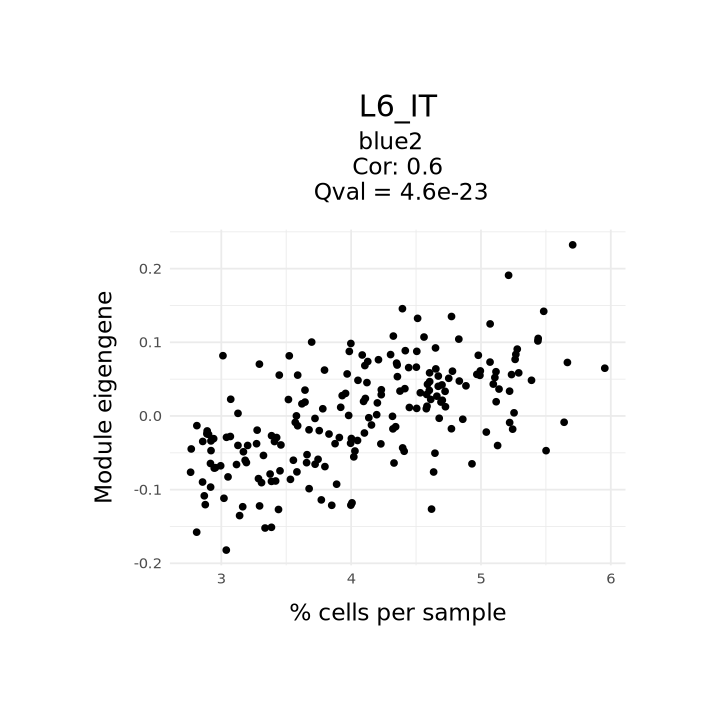

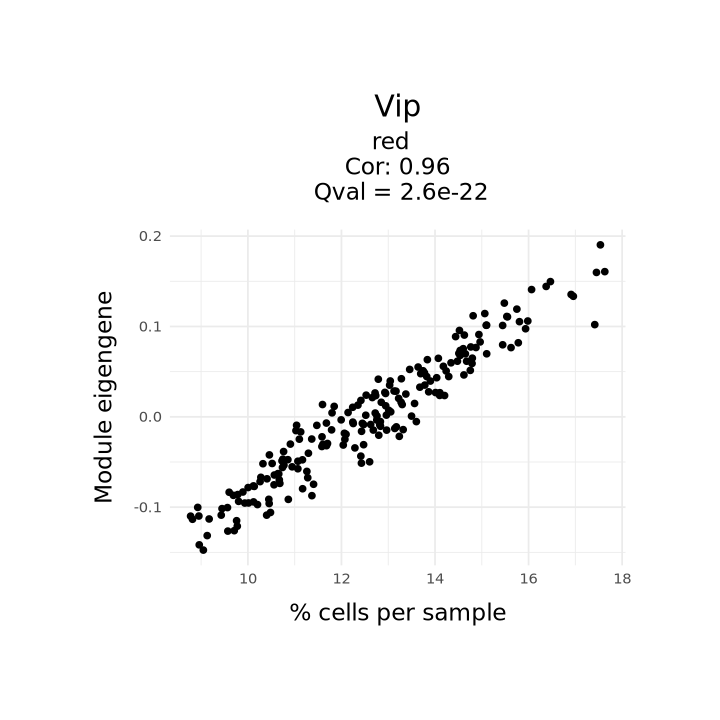

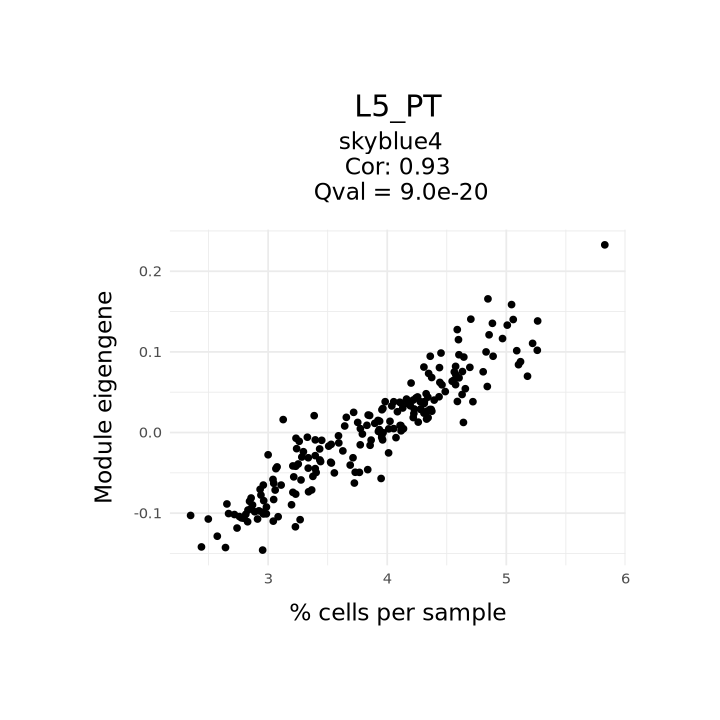

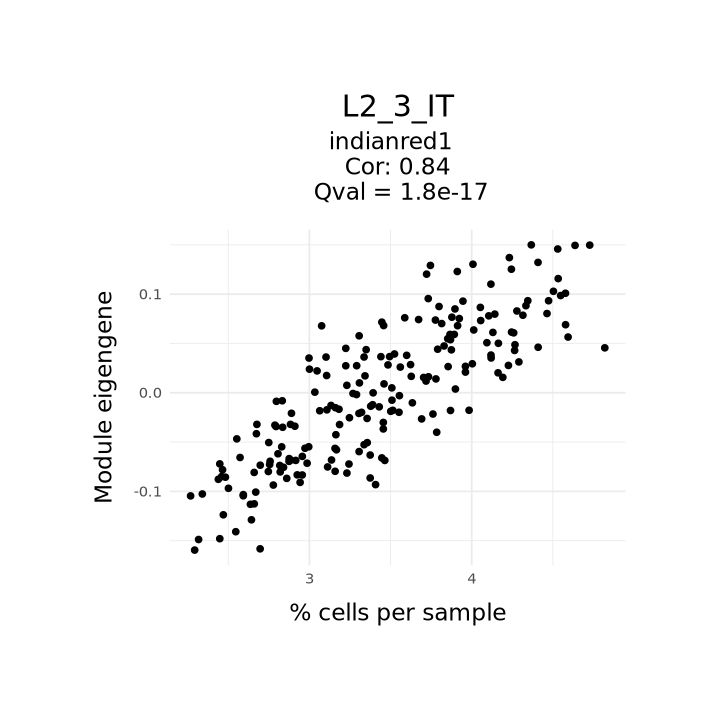

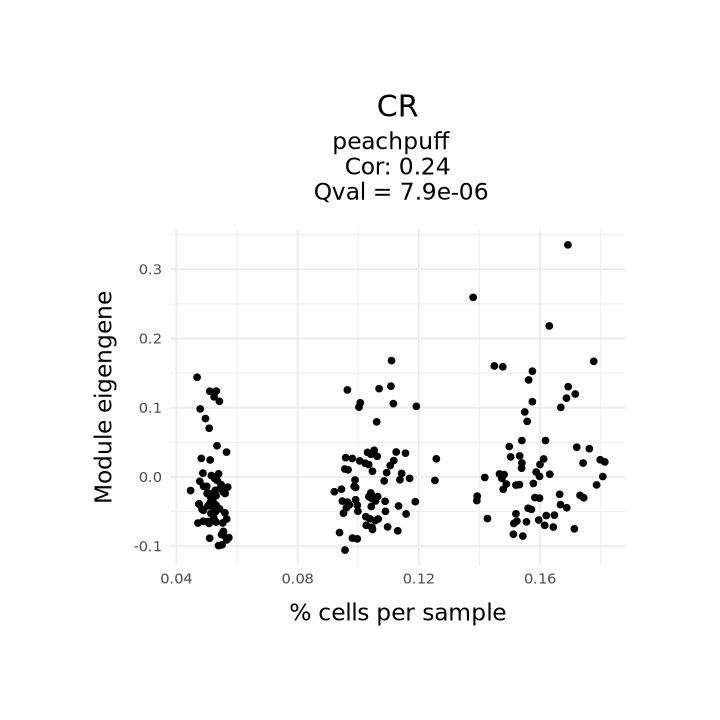

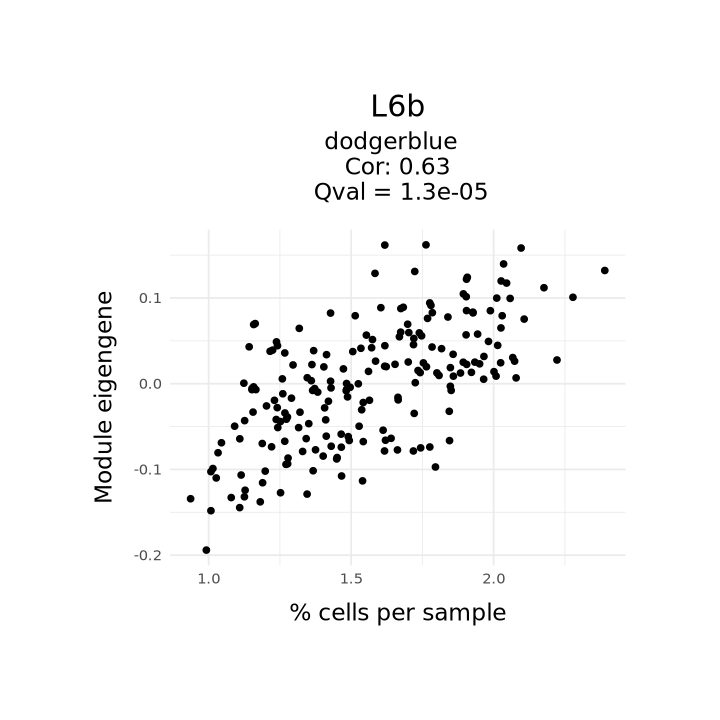

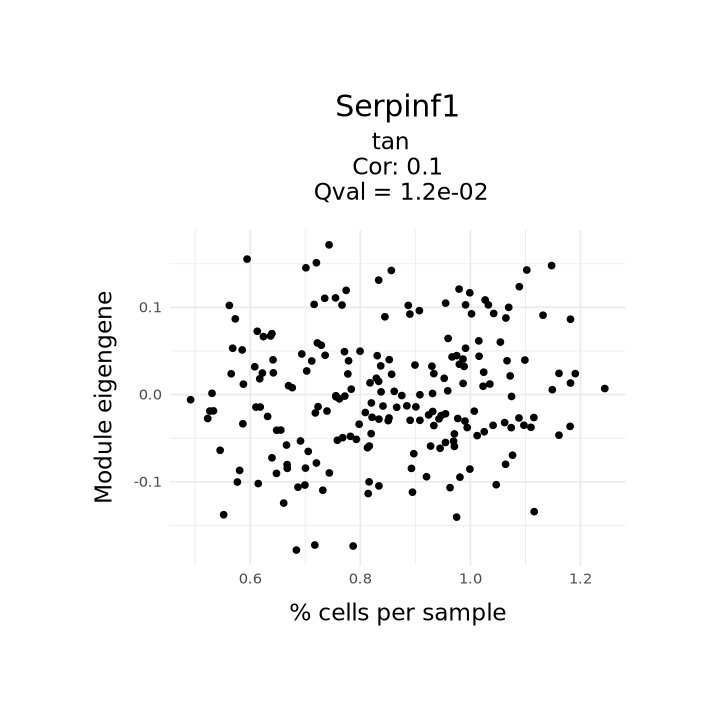

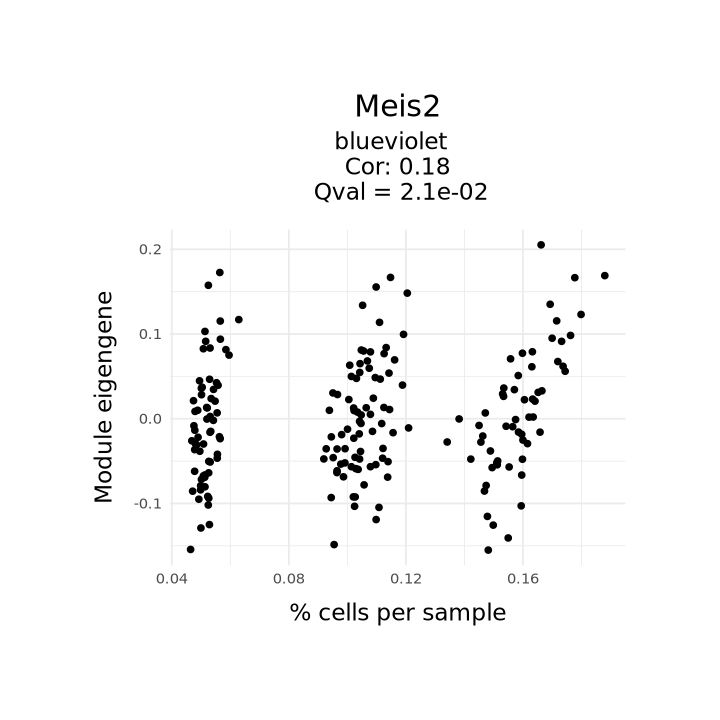

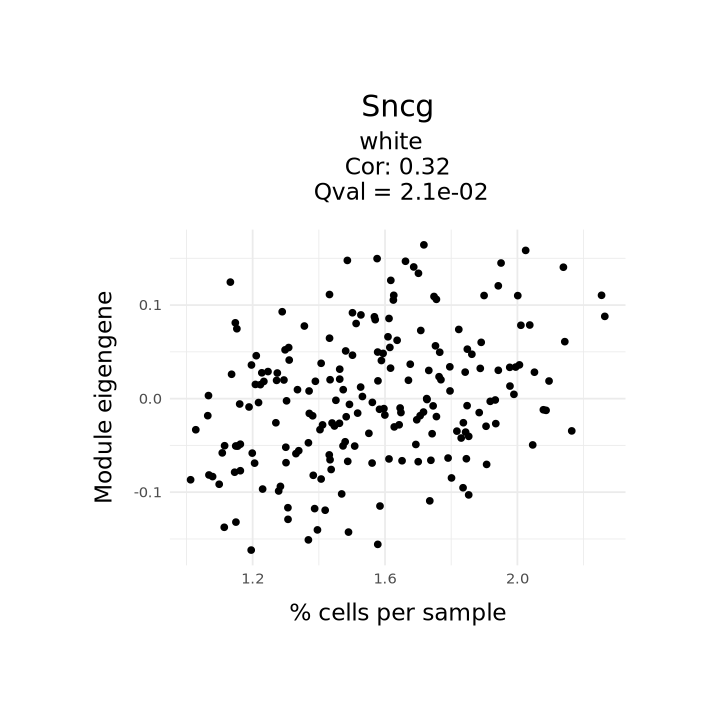

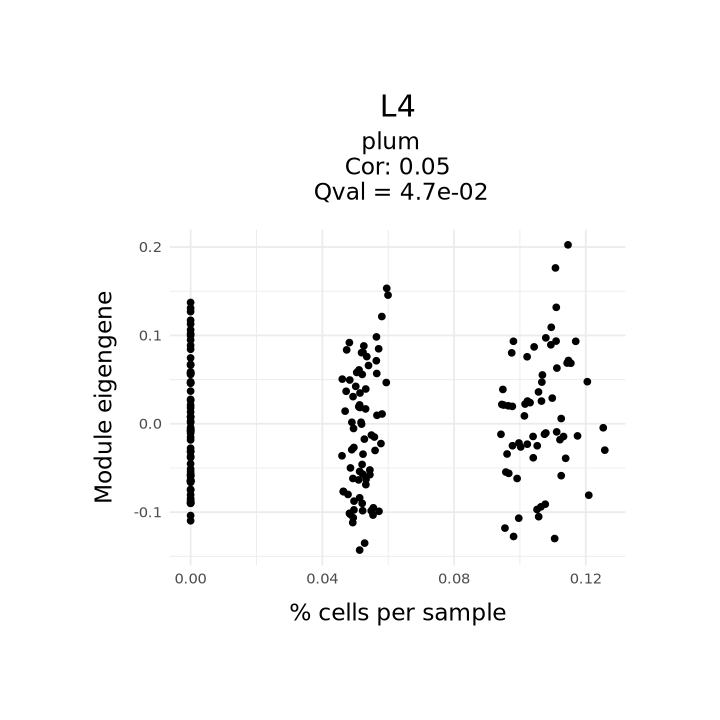

In [33]:
plot_ctype_abundance_vs_top_qval_ME(pseudobulk_legend, top_qval_mods_df)

# Round 2 (25 SD network; PosBC module definition)

In [ ]:
network_dir <- "tasic_2018_ALM_STAR_20pcntCells_25SD_200samples_log2_pseudobulk_Modules"

pseudobulk_legend <- read.csv("data/SyntheticDatasets/SyntheticDataset1_20pcntCells_25SD_200samples_legend_03-56-13.csv")
pseudobulk_legend$Cell.type <- gsub("/", "_", pseudobulk_legend$Cell.type, fixed=TRUE)
pseudobulk_legend$Cell.type <- gsub(" ", "_", pseudobulk_legend$Cell.type)

top_qval_mods_df <- read.csv("data/tasic_2018_ALM_STAR_donor_cell_type_pseudobulk_1_vs_mean_DE_genes_dream_20pcntCells_25SD_200samples_log2_pseudobulk_PosFDR_top_Qval_modules.csv")

In [68]:
ctype_genes_list <- pairwise_ctype_genes

top_corr_mods_25SD_PosBC_df <- get_top_corr_mods(network_dir, pseudobulk_legend, top_qval_mods_df, ctype_genes_list, mod_def)
top_corr_mods_25SD_PosBC_df %>% arrange(Old_cor)

,Cell_type,Pseudobulk_SD,Cor,Old_cor,Pval,Old_pval,Module_genes,Old_module_genes,DE_genes,Module,Old_module,Network,Old_network,ME_path,Old_ME_path,kME_path,Old_kME_path
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
cadetblue4,L5_IT,24.62,0.8540066,0.7025569,2.885240e-08,4.417915e-57,"Gfra2, Dkkl1, Cnih3, Opn3, Gtdc1, Tnnc1, Met, Ncam2, Ocm, Sccpdh, BC006965, Wnt9a, Ppef1, Scn7a, Lamc2","Nrn1, Hpca, Lmo4, Fars2, Stx1a, Car10, Kcnk4, Epha4, Krt12, Camk4, Medag, Ak4, Glt8d2, 4921539H07Rik, Lrrc4c","Tnnc1, Lemd1, Rorb, BC006965, F2rl2, Dkkl1, Wfdc18, Gm29674, Adcyap1, C030013G03Rik, Krt12, Hgf, Susd5, Cpne9, Rmst",cadetblue4,bisque4,Bicor-None_signum0.341_minSize5_merge_ME_0.9_20151,Bicor-None_signum0.341_minSize8_merge_ME_0.9_20151,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_25SD_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.341_minSize5_merge_ME_0.9_20151/Module_eigengenes_09-55-28.csv,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_25SD_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.341_minSize8_merge_ME_0.9_20151/Module_eigengenes_11-09-24.csv,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_25SD_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.341_minSize5_merge_ME_0.9_20151/kME_table_09-55-28.csv,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_25SD_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.341_minSize8_merge_ME_0.9_20151/kME_table_11-09-24.csv
magenta2,Vip,24.17,0.7863361,0.7863361,4.716323e-25,3.168548e-68,"Vip, Igf1, Asic4, Ap1s2, Vstm2l, Adra1b, Prox1os, Prox1, Crh, Fxyd6, Gm17750, Gm37264, Tac2, Asic1, Grpr","Vip, Igf1, Asic4, Ap1s2, Vstm2l, Adra1b, Prox1os, Synpr, Prox1, Crh, Fxyd6, Gm17750, Gm37264, Tac2, Asic1","Vip, Crh, Penk, Calb2, Pthlh, Slc5a7, Tac2, Grpr, Sostdc1, Slc18a3, Adarb2, Npy2r, Chat, Cp, Prox1os",magenta2,lightblue3,Bicor-None_signum0.305_minSize10_merge_ME_0.9_20151,Bicor-None_signum0.341_minSize10_merge_ME_0.9_20151,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_25SD_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.305_minSize10_merge_ME_0.9_20151/Module_eigengenes_12-39-51.csv,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_25SD_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.341_minSize10_merge_ME_0.9_20151/Module_eigengenes_11-29-24.csv,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_25SD_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.305_minSize10_merge_ME_0.9_20151/kME_table_12-39-51.csv,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_25SD_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.341_minSize10_merge_ME_0.9_20151/kME_table_11-29-24.csv
mediumpurple,L6_IT,22.61,0.8653515,0.8577590,3.612416e-28,1.354173e-34,"Gm2694, Cd7, Slc7a4, Glipr1, Cbln1, Rspo2, Sstr2, 5330416C01Rik, Kash5, Gm49678, Blnk, Oprk1, Spink8, Gpr52, Pgam2","Gm2694, Cd7, Glipr1, Slc7a4, Cbln1, Rspo2, Sstr2, 5330416C01Rik, Kash5, Gm49678, Blnk, Gkn1, 2810404M03Rik, Oprk1, Spink8","Glipr1, Ccdc3, Blnk, Dmkn, Gm34567, Htra4, Marcksl1, Sulf1, Inhba, Oprk1, Aspg, Efcab6, Cd7, Rasl10a, Gm2694",mediumpurple,lightpink,Bicor-None_signum0.481_minSize4_merge_ME_0.9_20151,Bicor-None_signum0.341_minSize10_merge_ME_0.9_20151,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_25SD_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.481_minSize4_merge_ME_0.9_20151/Module_eigengenes_07-21-34.csv,/mnt/l

In [61]:
ctype_genes_list <- pairwise_ctype_genes

top_corr_mods_25SD_PosBC_df <- get_top_corr_mods(network_dir, pseudobulk_legend, top_qval_mods_df, ctype_genes_list, mod_def)
top_corr_mods_25SD_PosBC_df %>% arrange(Old_cor)

,Cell_type,Pseudobulk_SD,Cor,Old_cor,Pval,Old_pval,Module_genes,Old_module_genes,DE_genes,Module,Old_module,Network,Old_network,ME_path,Old_ME_path,kME_path,Old_kME_path
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
cadetblue4,L5_IT,24.62,0.8540066,0.7025569,1.559899e-05,3.525397e-38,"Gfra2, Dkkl1, Cnih3, Opn3, Gtdc1, Tnnc1, Met, Ncam2, Ocm, Sccpdh, BC006965, Wnt9a, Ppef1, Scn7a, Lamc2","Nrn1, Hpca, Lmo4, Fars2, Stx1a, Car10, Kcnk4, Epha4, Krt12, Camk4, Medag, Ak4, Glt8d2, 4921539H07Rik, Lrrc4c","Tnnc1, Lemd1, Rorb, BC006965, F2rl2, Dkkl1, Wfdc18, Gm29674, Adcyap1, C030013G03Rik, Krt12, Hgf, Susd5, Cpne9, Rmst",cadetblue4,bisque4,Bicor-None_signum0.341_minSize5_merge_ME_0.9_20151,Bicor-None_signum0.341_minSize8_merge_ME_0.9_20151,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_25SD_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.341_minSize5_merge_ME_0.9_20151/Module_eigengenes_09-55-28.csv,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_25SD_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.341_minSize8_merge_ME_0.9_20151/Module_eigengenes_11-09-24.csv,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_25SD_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.341_minSize5_merge_ME_0.9_20151/kME_table_09-55-28.csv,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_25SD_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.341_minSize8_merge_ME_0.9_20151/kME_table_11-09-24.csv
magenta2,Vip,24.17,0.7863361,0.7863361,9.293154e-29,3.035687e-68,"Vip, Igf1, Asic4, Ap1s2, Vstm2l, Adra1b, Prox1os, Prox1, Crh, Fxyd6, Gm17750, Gm37264, Tac2, Asic1, Grpr","Vip, Igf1, Asic4, Ap1s2, Vstm2l, Adra1b, Prox1os, Synpr, Prox1, Crh, Fxyd6, Gm17750, Gm37264, Tac2, Asic1","Vip, Crh, Penk, Calb2, Pthlh, Slc5a7, Tac2, Grpr, Sostdc1, Slc18a3, Adarb2, Npy2r, Chat, Cp, Prox1os",magenta2,lightblue3,Bicor-None_signum0.305_minSize10_merge_ME_0.9_20151,Bicor-None_signum0.341_minSize10_merge_ME_0.9_20151,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_25SD_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.305_minSize10_merge_ME_0.9_20151/Module_eigengenes_12-39-51.csv,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_25SD_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.341_minSize10_merge_ME_0.9_20151/Module_eigengenes_11-29-24.csv,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_25SD_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.305_minSize10_merge_ME_0.9_20151/kME_table_12-39-51.csv,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_25SD_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.341_minSize10_merge_ME_0.9_20151/kME_table_11-29-24.csv
mediumpurple,L6_IT,22.61,0.8653515,0.8577590,2.935644e-27,3.034855e-36,"Gm2694, Cd7, Slc7a4, Glipr1, Cbln1, Rspo2, Sstr2, 5330416C01Rik, Kash5, Gm49678, Blnk, Oprk1, Spink8, Gpr52, Pgam2","Gm2694, Cd7, Glipr1, Slc7a4, Cbln1, Rspo2, Sstr2, 5330416C01Rik, Kash5, Gm49678, Blnk, Gkn1, 2810404M03Rik, Oprk1, Spink8","Glipr1, Ccdc3, Blnk, Dmkn, Gm34567, Htra4, Marcksl1, Sulf1, Inhba, Oprk1, Aspg, Efcab6, Cd7, Rasl10a, Gm2694",mediumpurple,lightpink,Bicor-None_signum0.481_minSize4_merge_ME_0.9_20151,Bicor-None_signum0.341_minSize10_merge_ME_0.9_20151,/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_25SD_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.481_minSize4_merge_ME_0.9_20151/Module_eigengenes_07-21-34.csv,/mnt/l

In [64]:
colnames(top_corr_mods_25SD_PosBC_df)

[1] "Cell_type"     "Cor"           "Old_cor"       "Module"       
 [5] "Old_module"    "Network"       "Old_network"   "Qval"         
 [9] "Old_qval"      "Pseudobulk_SD" "New_ME_path"   "New_kME_path"

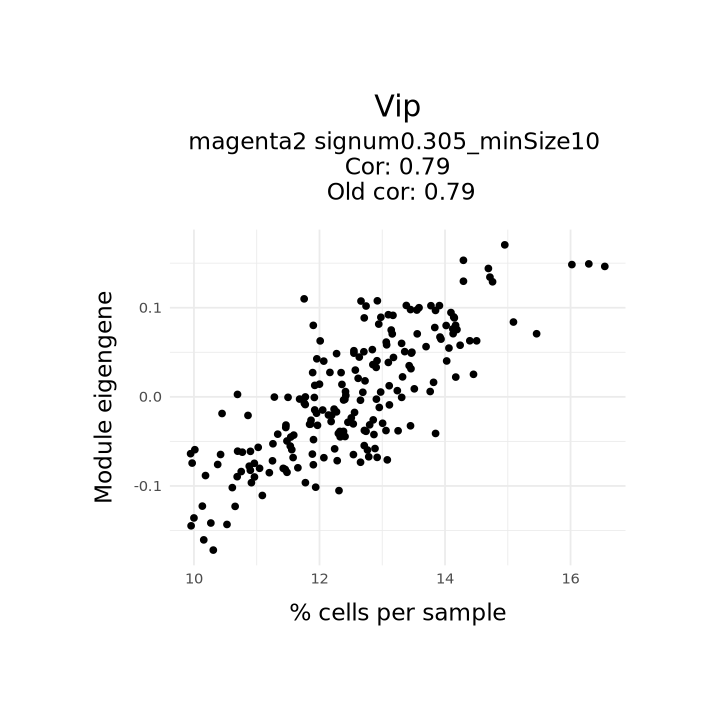

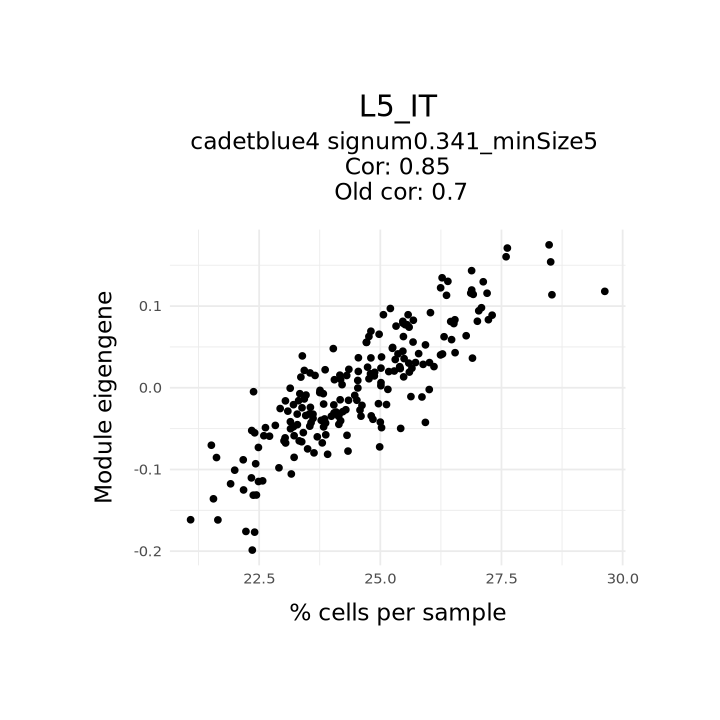

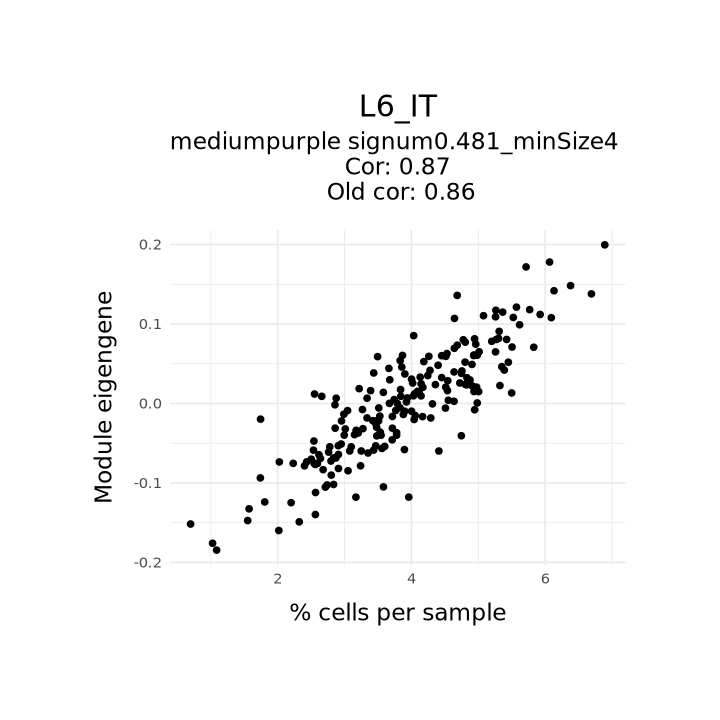

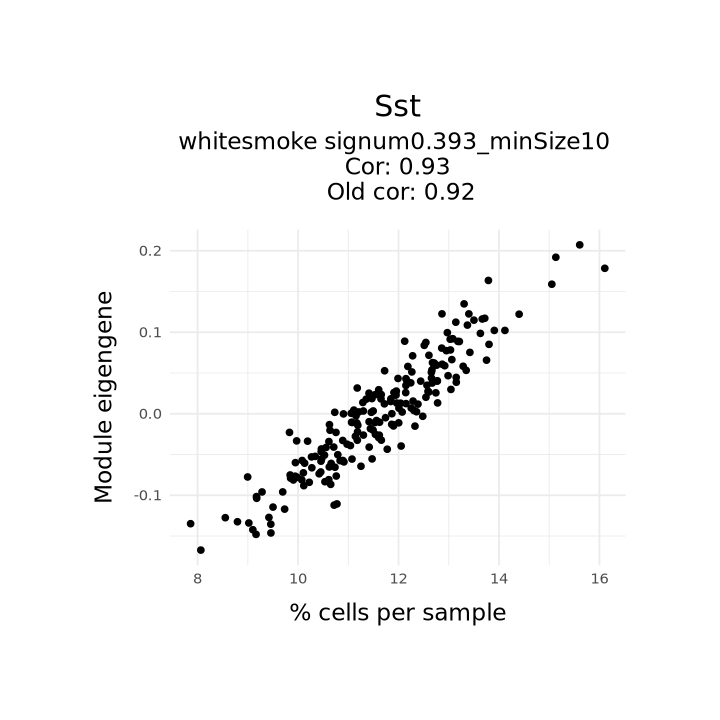

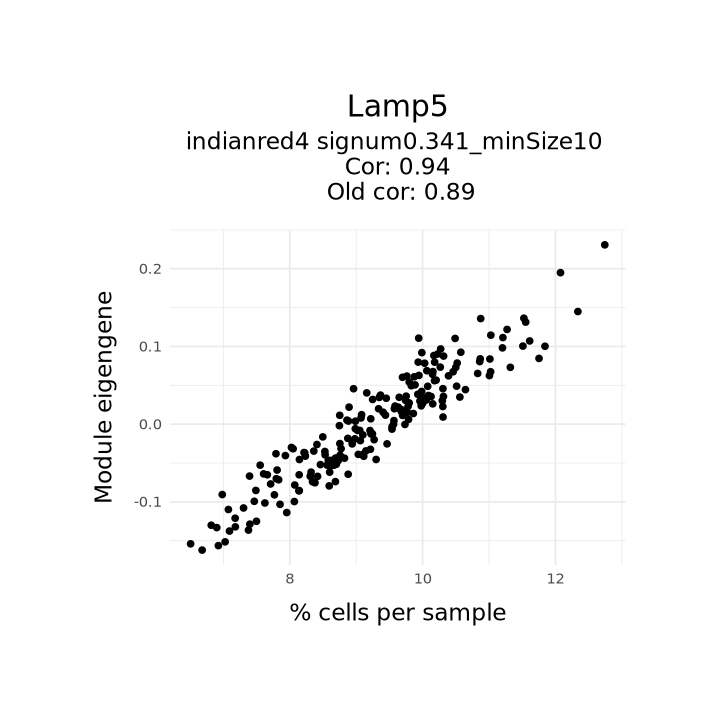

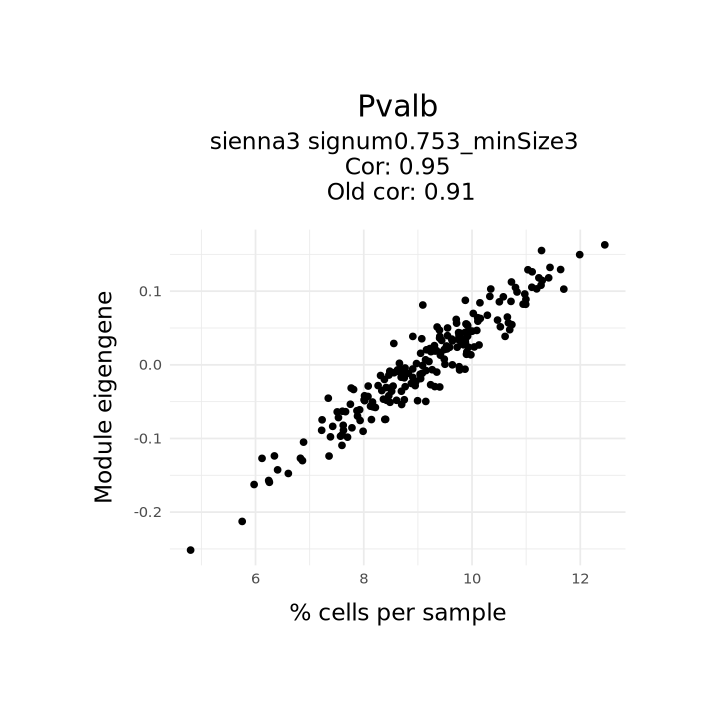

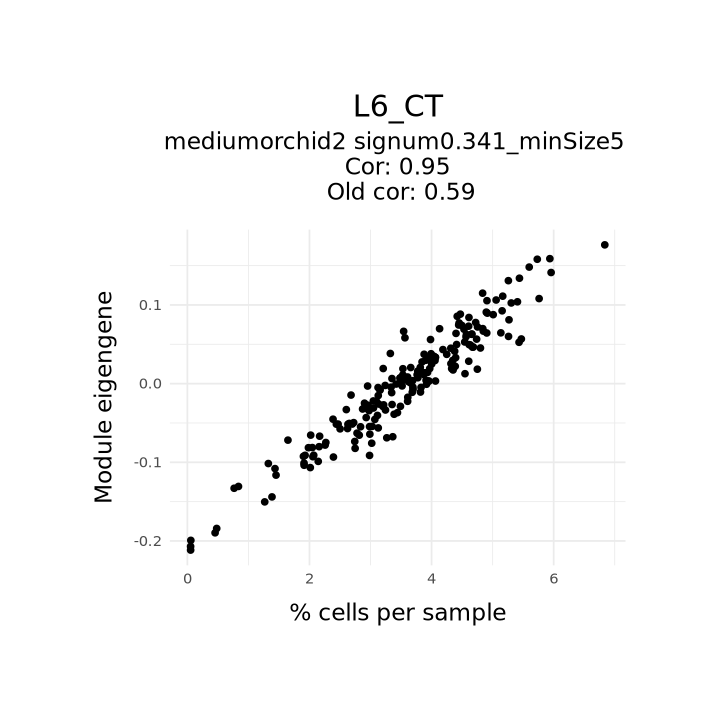

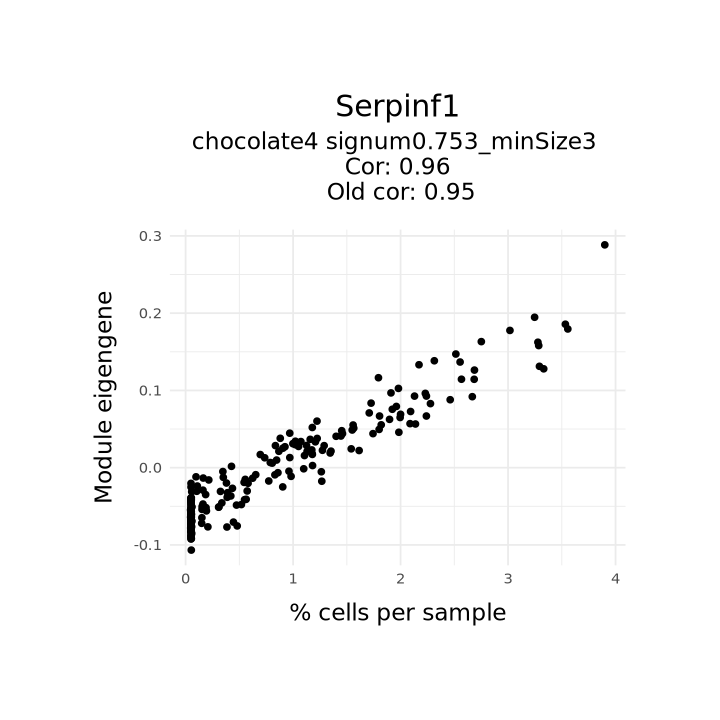

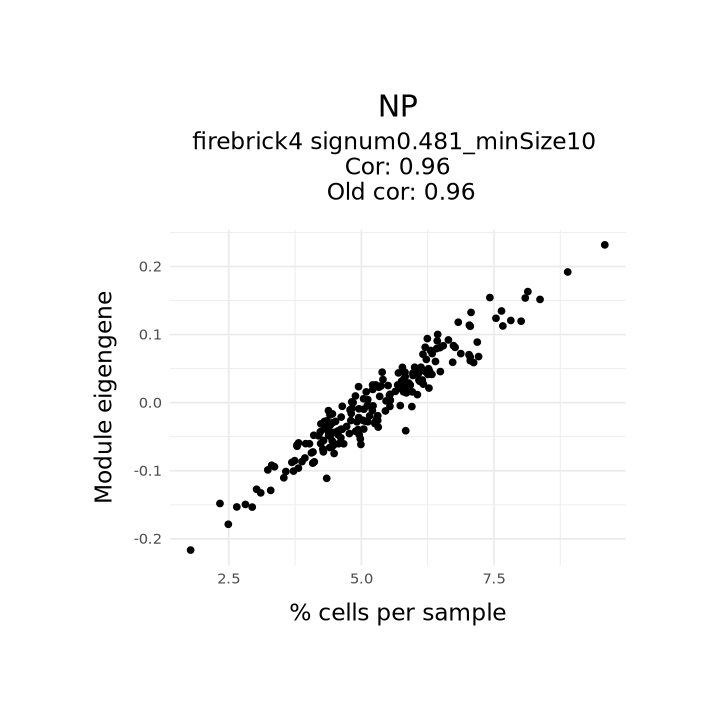

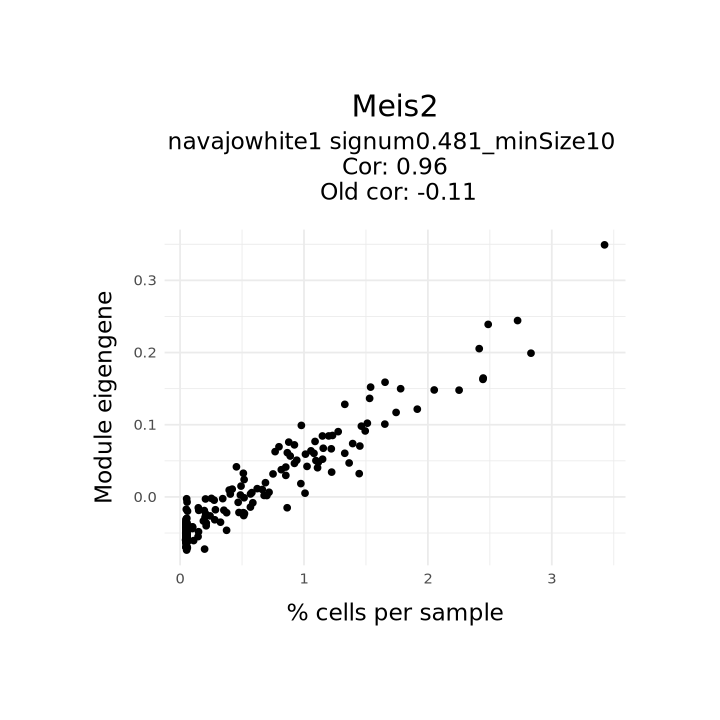

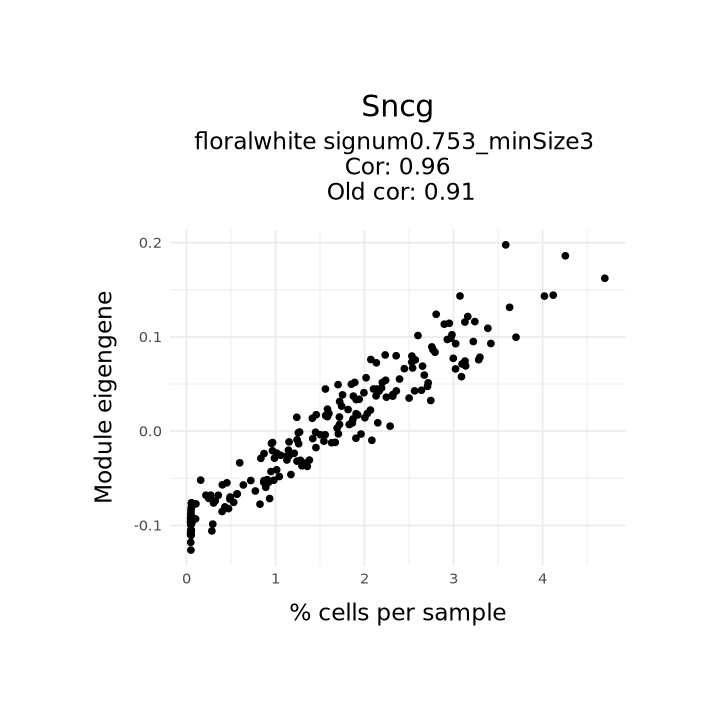

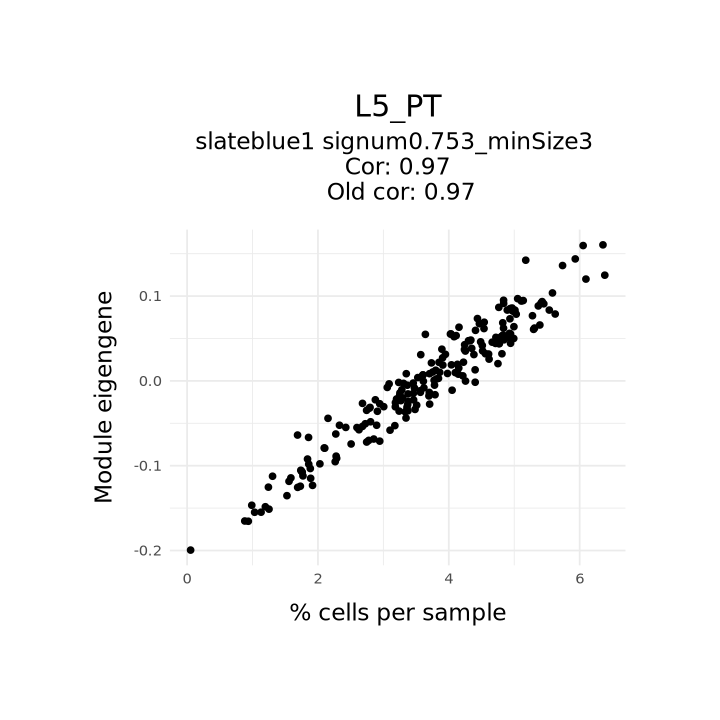

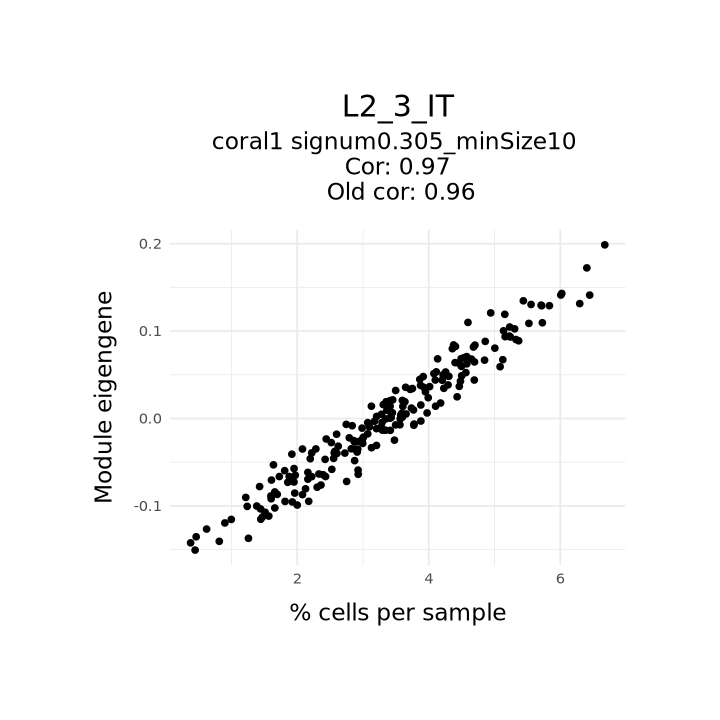

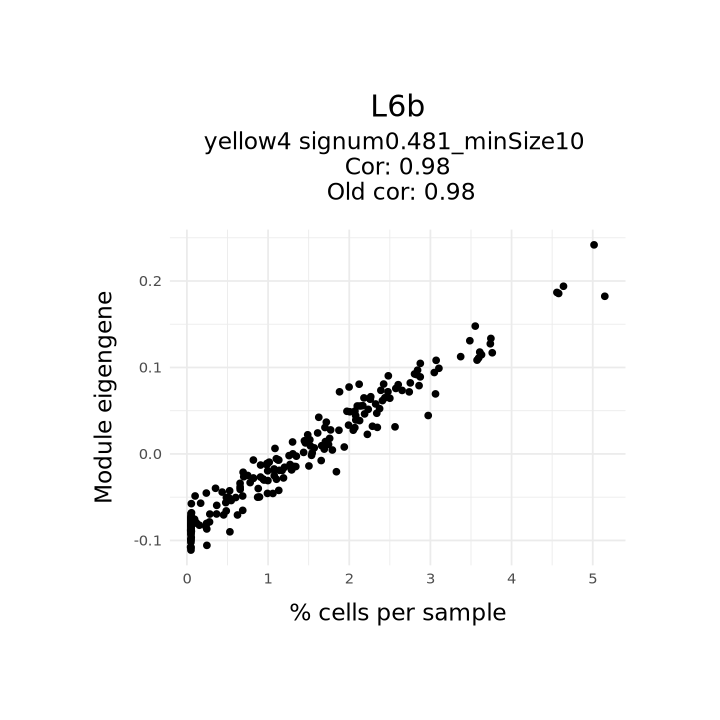

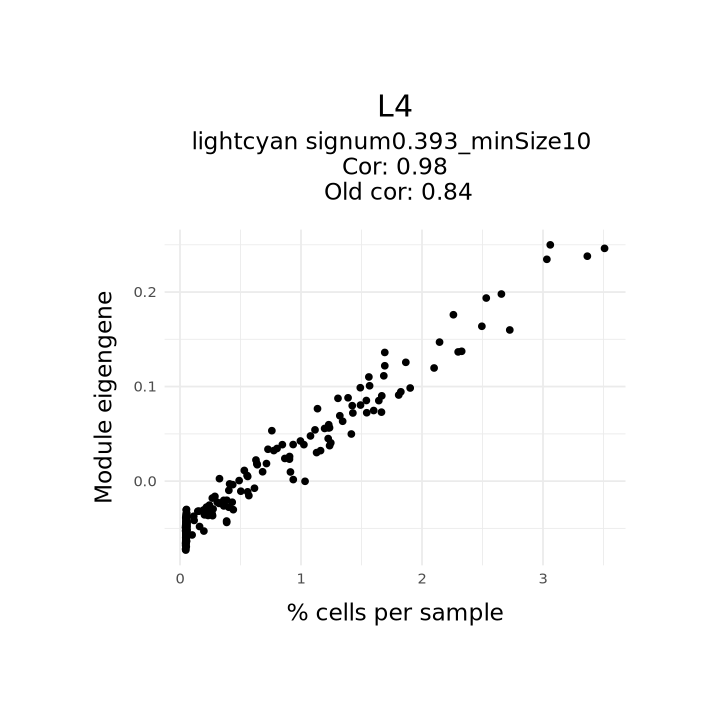

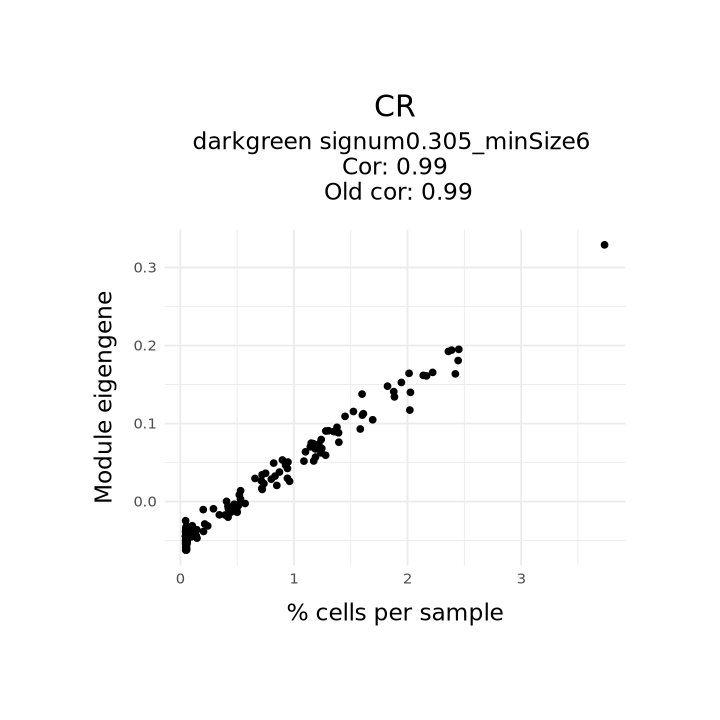

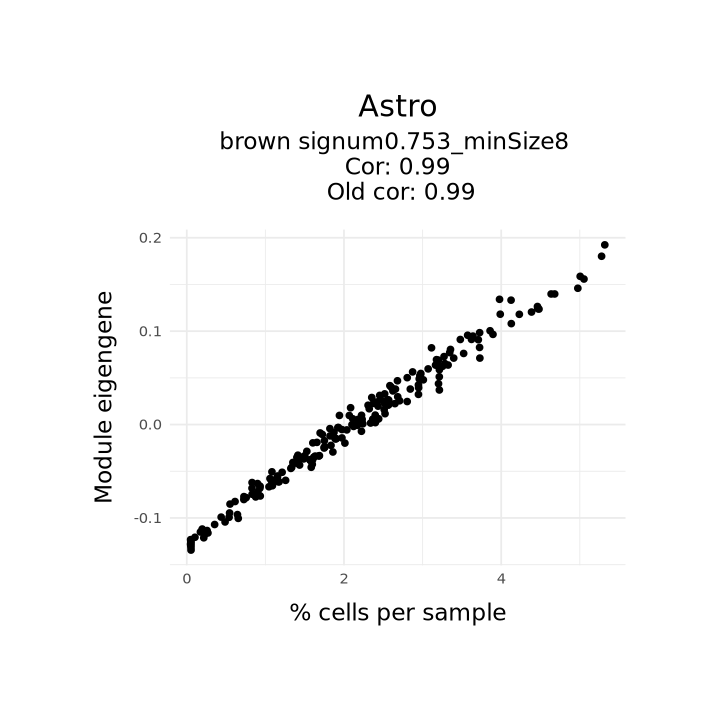

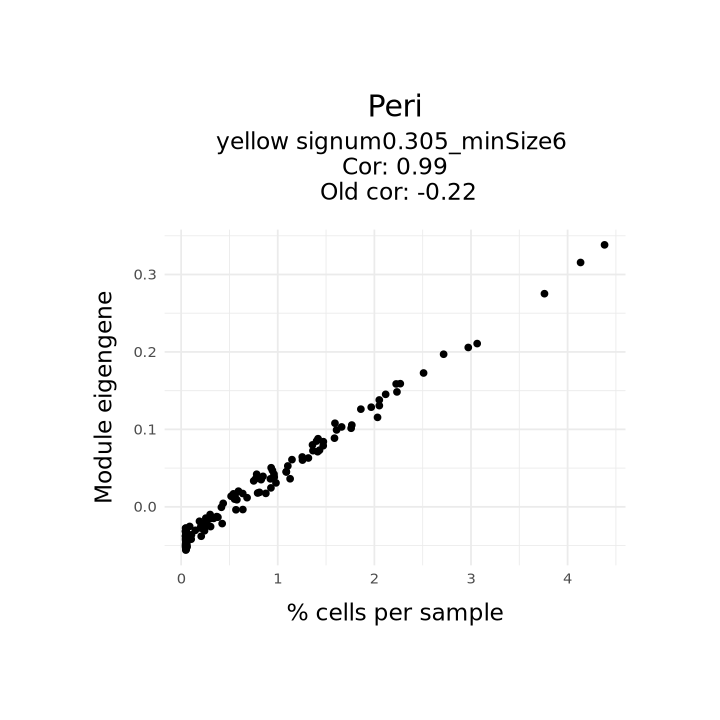

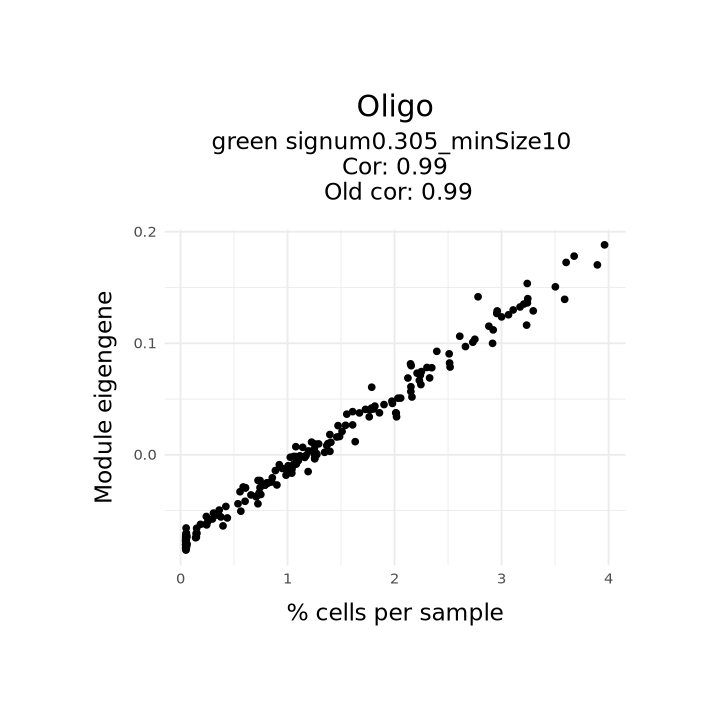

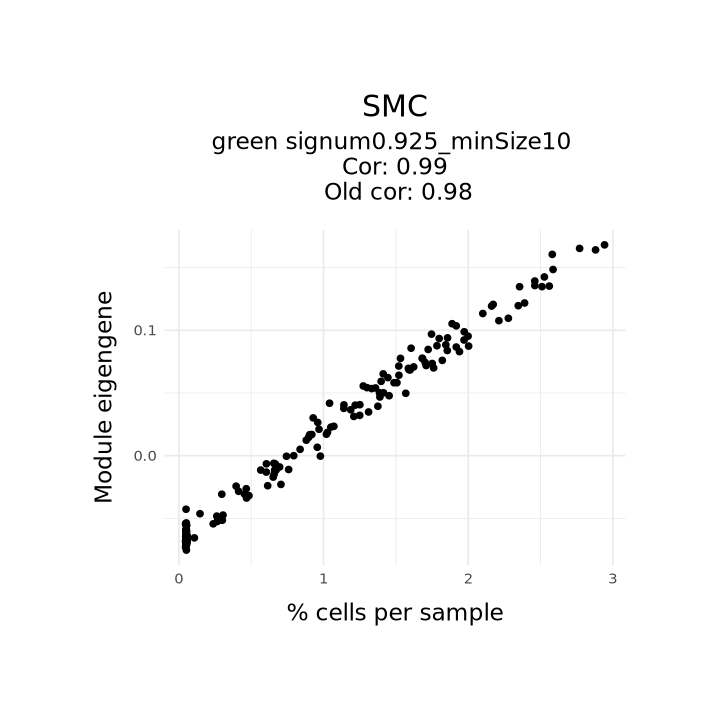

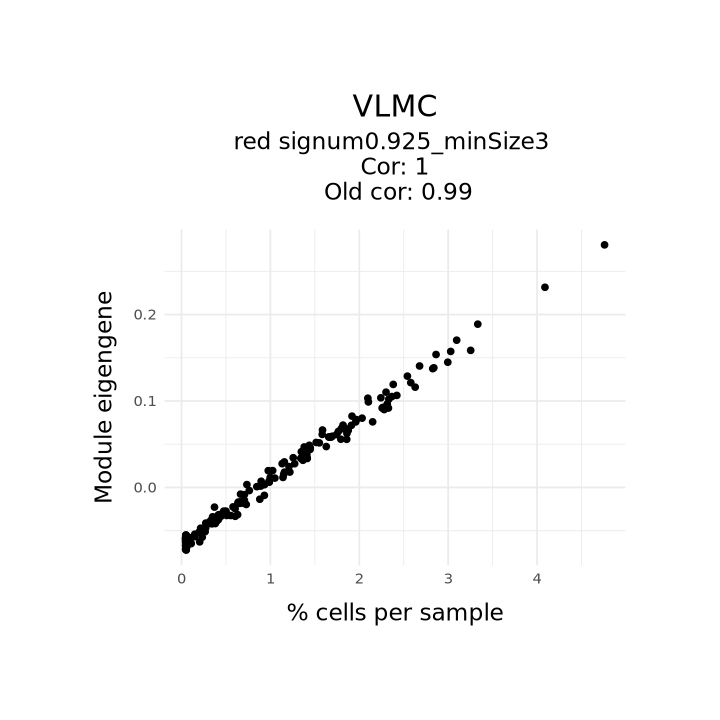

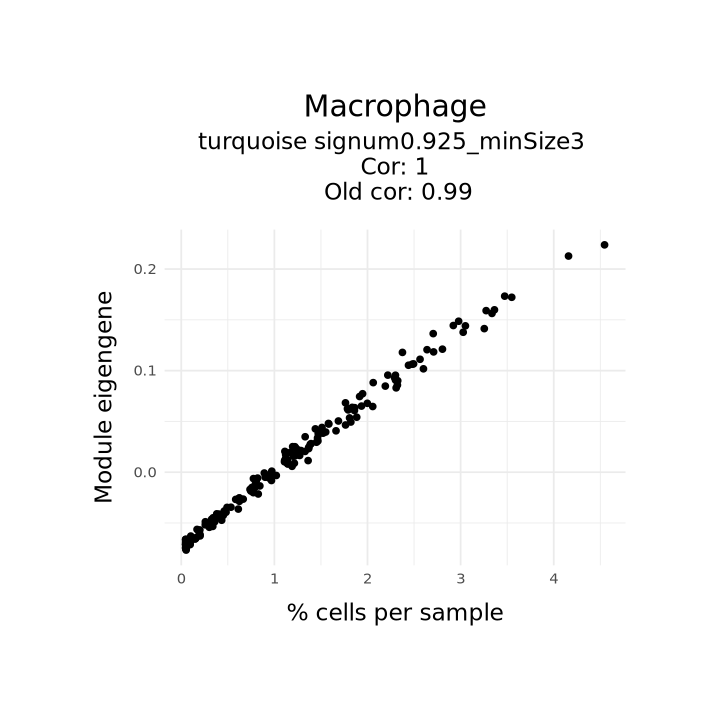

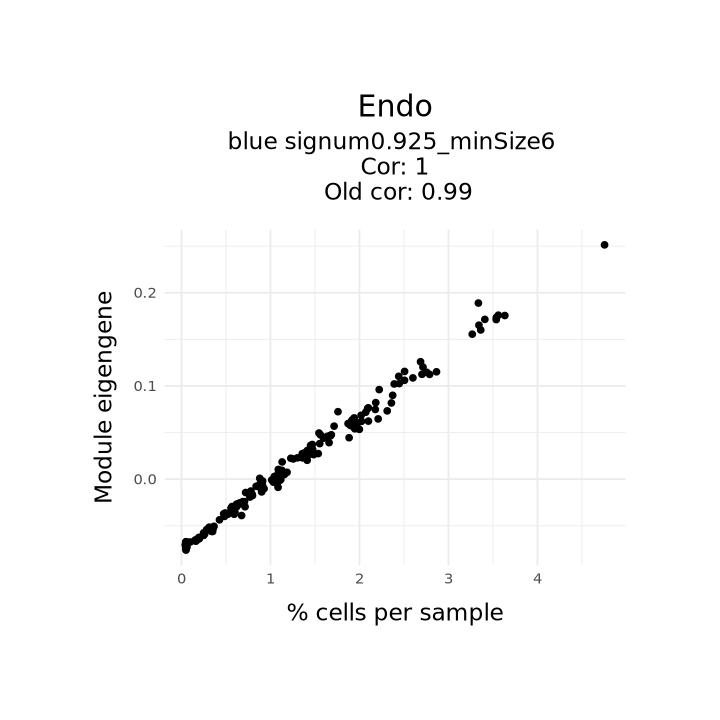

In [55]:
plot_ctype_abundance_vs_top_corr_ME(pseudobulk_legend, top_corr_mods_25SD_PosBC_df)

In [ ]:
top_corr_mods_25SD_PosBC_df$New_ME_path

# Concatonate results

In [ ]:
# top_corr_mods_30pcnt_PosBC_df$Data <- "30pcnt_PosBC"
top_corr_mods_50pcnt_PosBC_df$Data <- "50pcnt_PosBC"
top_corr_mods_20SD_PosBC_df$Data <- "25SD_PosBC"

In [80]:
top_corr_mods_0.4pcnt_PosBC_df <- get_top_corr_mod_stats(top_corr_mods_0.4pcnt_PosBC_df)
top_corr_mods_25kappa_PosBC_df <- get_top_corr_mod_stats(top_corr_mods_25kappa_PosBC_df)
# top_corr_mods_40pcnt_PosBC_df <- get_top_corr_mod_stats(top_corr_mods_40pcnt_PosBC_df)
top_corr_mods_50pcnt_PosBC_df <- get_top_corr_mod_stats(top_corr_mods_50pcnt_PosBC_df)
top_corr_mods_20SD_PosBC_df <- get_top_corr_mod_stats(top_corr_mods_20SD_PosBC_df)

In [81]:
cols_idx <- which(colnames(top_corr_mods_0.4pcnt_PosBC_df) %in% c("Cell_type", "Cor", "Old_cor", "Pseudobulk_SD", "PC1V1", "MeanExpr", "Unique_members", "Specificity", "Homogeneity"))

In [82]:
colnames(top_corr_mods_0.4pcnt_PosBC_df)[-1] <- paste0(
    colnames(top_corr_mods_0.4pcnt_PosBC_df)[-1], "_", top_corr_mods_0.4pcnt_PosBC_df$Data[1]
)

colnames(top_corr_mods_25kappa_PosBC_df)[-1] <- paste0(
    colnames(top_corr_mods_25kappa_PosBC_df)[-1], "_", top_corr_mods_25kappa_PosBC_df$Data[1]
)

# colnames(top_corr_mods_40pcnt_PosBC_df)[-1] <- paste0(
#     colnames(top_corr_mods_40pcnt_PosBC_df)[-1], "_", top_corr_mods_40pcnt_PosBC_df$Data[1]
# )

colnames(top_corr_mods_50pcnt_PosBC_df)[-1] <- paste0(
    colnames(top_corr_mods_50pcnt_PosBC_df)[-1], "_", top_corr_mods_50pcnt_PosBC_df$Data[1]
)

colnames(top_corr_mods_20SD_PosBC_df)[-1] <- paste0(
    colnames(top_corr_mods_20SD_PosBC_df)[-1], "_", top_corr_mods_20SD_PosBC_df$Data[1]
)

### Compare PosBC results

In [83]:
top_corr_mods_BC_df <- merge(
    top_corr_mods_0.4pcnt_PosBC_df[,cols_idx],
    top_corr_mods_25kappa_PosBC_df[,cols_idx],
    by="Cell_type", all=TRUE, sort=FALSE
)

# top_corr_mods_BC_df <- merge(
#     top_corr_mods_BC_df,
#     top_corr_mods_40pcnt_PosBC_df[,cols_idx],
#     by="Cell_type", all=TRUE, sort=FALSE
# )

top_corr_mods_BC_df <- merge(
    top_corr_mods_BC_df,
    top_corr_mods_50pcnt_PosBC_df[,cols_idx],
    by="Cell_type", all=TRUE, sort=FALSE
)

top_corr_mods_BC_df <- merge(
    top_corr_mods_BC_df,
    top_corr_mods_20SD_PosBC_df[,cols_idx],
    by="Cell_type", all=TRUE, sort=FALSE
)

top_corr_mods_BC_df <- top_corr_mods_BC_df[,order(colnames(top_corr_mods_BC_df))]

top_corr_mods_BC_df <- merge(
    top_corr_mods_BC_df,
    data.frame(sort(table(cell_meta$cell_subclass))), 
    by.x="Cell_type", by.y="Var1", all=TRUE
)


ERROR: Error in `[.data.frame`(top_corr_mods_20SD_PosBC_df, , cols_idx): undefined columns selected


In [86]:
cols_idx

[1]  1 19 20 21 23

In [85]:
top_corr_mods_20SD_PosBC_df[,cols_idx]

ERROR: Error in `[.data.frame`(top_corr_mods_20SD_PosBC_df, , cols_idx): undefined columns selected


In [59]:
# top_corr_mods_0.4pcnt_PosBC_df[top_corr_mods_0.4pcnt_PosBC_df$Cell_type == "Sncg",]
# kME_df <- fread("/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM/tasic_2018_ALM_STAR_20pcntCells_0.4pcntVar_200samples_log2_pseudobulk_Modules/Bicor-None_signum0.586_minSize3_merge_ME_0.9_20151/kME_table_06-18-43.csv")
# top_genes <- kME_df[kME_df$`TopModPosBC_8.11e-09` == "darkorchid2", c("Gene", "kMEdarkorchid2")] %>% arrange(-kMEdarkorchid2)
# top_genes
# write.csv(top_genes, file="top_genes.csv", row.names=FALSE)

In [60]:
top_corr_mods_BC_df %>%
  relocate(Freq, .after=Cell_type) %>%
  arrange(Freq)

Cell_type,Freq,Cor_0.4pcnt_PosBC,Cor_15kappa_PosBC,Cor_25kappa_PosBC,Cor_50pcnt_PosBC,Homogeneity_0.4pcnt_PosBC,Homogeneity_15kappa_PosBC,Homogeneity_25kappa_PosBC,Homogeneity_50pcnt_PosBC,MeanExpr_0.4pcnt_PosBC,MeanExpr_15kappa_PosBC,MeanExpr_25kappa_PosBC,MeanExpr_50pcnt_PosBC,Old_cor_0.4pcnt_PosBC,Old_cor_15kappa_PosBC,Old_cor_25kappa_PosBC,Old_cor_50pcnt_PosBC,Pseudobulk_SD_0.4pcnt_PosBC,Pseudobulk_SD_15kappa_PosBC,Pseudobulk_SD_25kappa_PosBC,Pseudobulk_SD_50pcnt_PosBC,Specificity_0.4pcnt_PosBC,Specificity_15kappa_PosBC,Specificity_25kappa_PosBC,Specificity_50pcnt_PosBC,Unique_members_0.4pcnt_PosBC,Unique_members_15kappa_PosBC,Unique_members_25kappa_PosBC,Unique_members_50pcnt_PosBC
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>
L4,3,NA,0.1504011,NA,0.2015220,NA,0.9927239,NA,0.8518490,NA,0.02272678,NA,0.01048402,NA,-0.02461285,NA,0.07698462,NA,0.38,NA,0.70,NA,47.8902954,NA,15.384615,NA,1135,NA,16
Peri,4,NA,0.2522680,0.1932410,0.1873673,NA,0.9852596,0.9496533,0.8790533,NA,0.08992893,0.44847966,0.18663322,NA,-0.07314448,0.05267446,-0.16100388,NA,0.51,0.65,0.73,NA,31.3086199,1.272265,8.854167,NA,701,35,17
CR,11,0.2291747,0.2070011,0.2303541,0.1490367,0.8710563,0.8904172,0.9159445,0.8927302,1.64015820,0.35906558,0.57507761,0.24836634,0.129101599,0.19327209,-0.06763805,-0.04376170,0.50,1.57,1.96,0.79,15.2284264,0.9268795,3.276898,10.283688,60,27,60,29
Meis2,11,0.2845981,0.2302433,0.3125991,0.1785107,0.7874547,0.9949139,0.8567619,0.8068180,0.01416564,0.04396504,0.35663564,0.96078083,0.149229893,0.08630561,-0.05137787,-0.08011696,0.50,2.02,2.71,0.74,100.0000000,11.9687771,2.027679,1.056710,7,138,63,30
SMC,55,0.9590460,0.7395172,0.8800080,0.8828202,0.9391225,0.9208406,0.9295218,0.9908321,0.28830932,0.11532388,0.12901273,0.78549982,0.958120433,0.73951723,0.88000800,0.87072285,2.93,13.40,11.55,4.11,53.4188034,22.2368421,24.531377,72.924188,125,507,301,202
VLMC,72,0.9211118,0.8225798,0.9117353,0.8453615,0.9229145,0.9507406,0.9852843,0.9242816,0.19250877,0.12239295,0.26176473,0.18344373,0.921111791,0.63806227,0.90136592,0.83210083,3.63,13.34,16.84,5.17,79.2114695,20.8333333,26.007523,70.877193,221,195,484,202
Serpinf1,78,0.7316211,0.3208066,0.4026167,0.1938398,0.6688854,0.9322153,0.9733656,0.8321743,0.49548560,0.28545641,0.29056466,0.93084122,0.276181507,0.30009104,0.30979272,0.07748015,4.20,16.00,16.64,5.23,31.7073171,1.3323464,3.448276,0.656304,13,36,66,19
Macrophage,85,0.9739987,0.9103410,0.9965619,0.8790042,0.9833021,0.9787520,0.9982113,0.9938854,0.32976571,0.01655297,0.32746280,0.68189793,0.952347615,0.88073115,0.97445447,0.87358583,4.47,18.47,17.12,5.79,95.4687500,38.4100045,87.630058,93.563579,611,860,1516,596
Macrophage,85,0.9739987,0.9103410,0.9965619,0.8790042,0.9833021,0.9787520,0.9982113,0.9938854,0.32976571,0.01655297,0.32746280,0.68189793,0.952347615,0.88073115,0.97445447,0.87409913,4.47,18.47,17.12,5.79,95.4687500,38.4100045,87.630058,93.563579,611,860,1516,596


### Some cell types that are not being well identified in **any** dataset:

No modules exist:
- Meis2 (11 cells)
- CR (11 cells)
- Peri (4 cells)
- L4 (3 cells)

Modules exist, but not being identified
- Serpinf1 (78 cells)
- Sncg (148 cells)

Modules exist, "decent" but not great modules being identifeid 
- L2_3_IT (325 cells)

# Misc

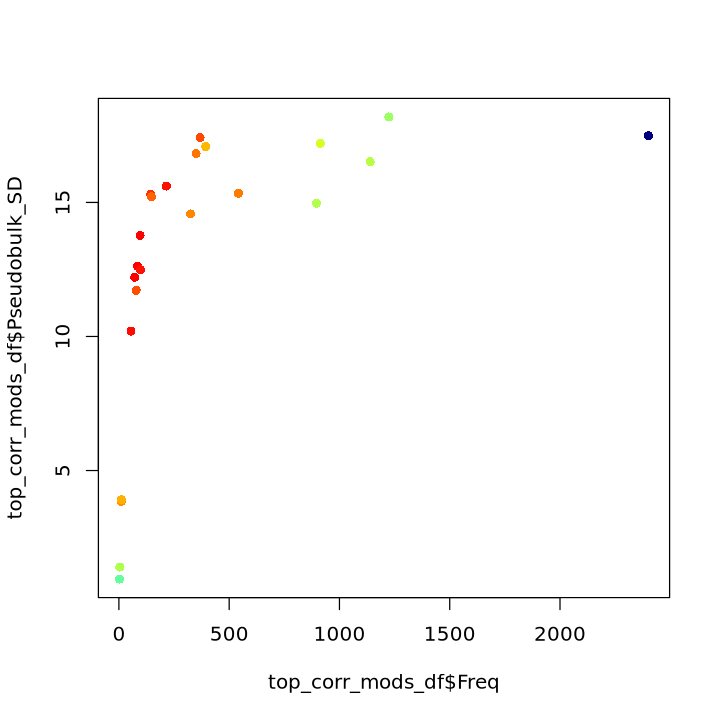

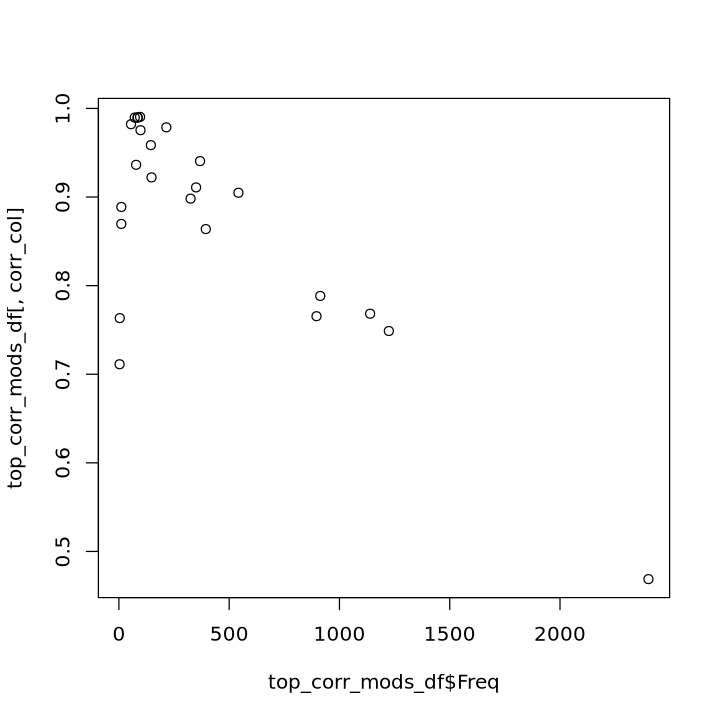

In [78]:
plot_corr_vs_stats(cell_meta, top_corr_mods_20SD_PosBC_df)

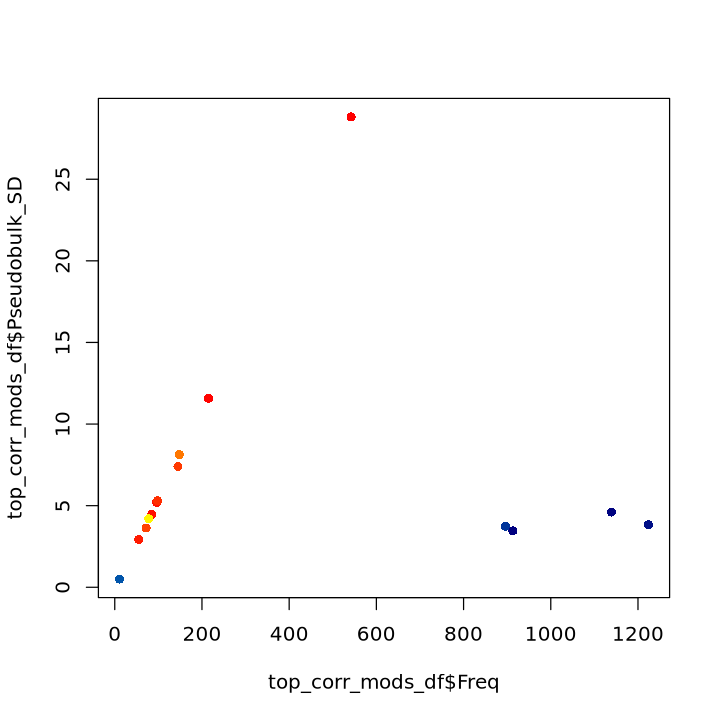

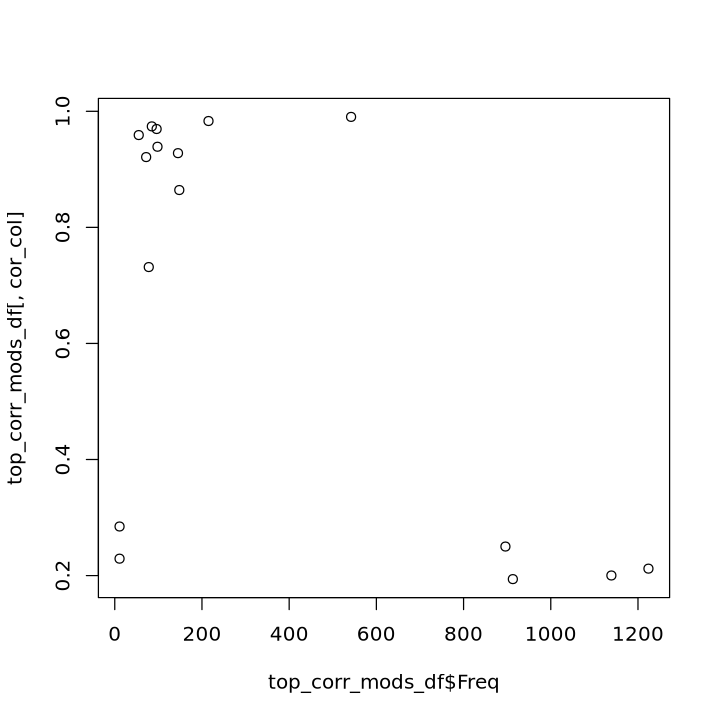

In [ ]:
plot_corr_vs_stats(cell_meta, top_corr_mods_0.4pcnt_PosBC_df)

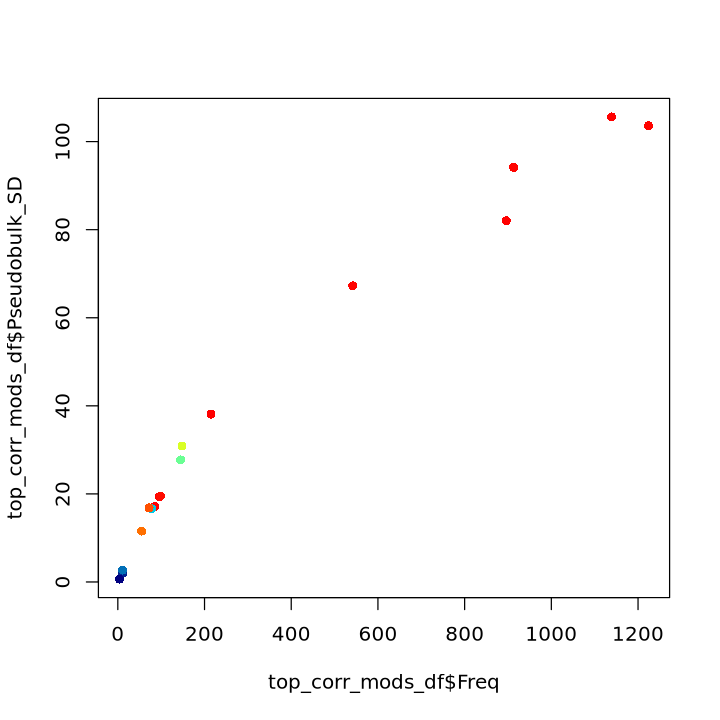

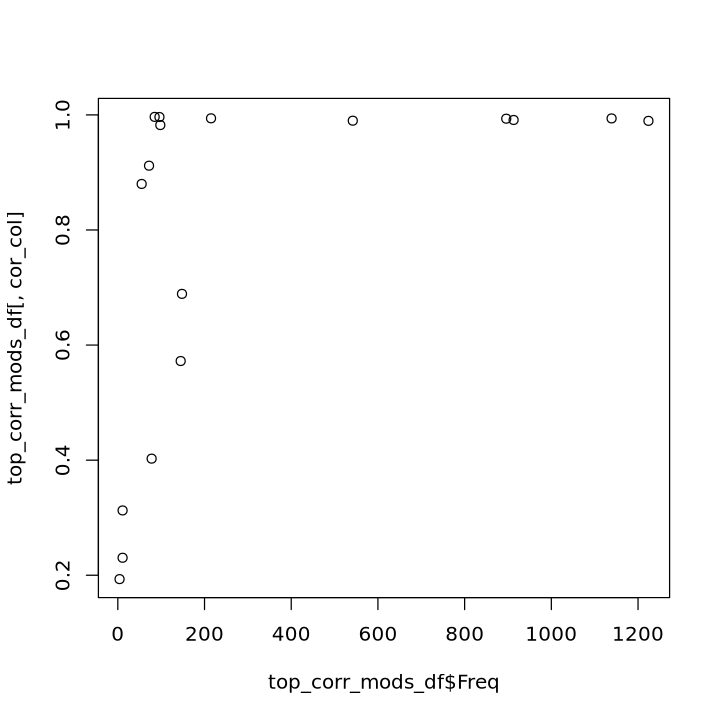

In [ ]:
plot_corr_vs_stats(cell_meta, top_corr_mods_25kappa_PosBC_df)

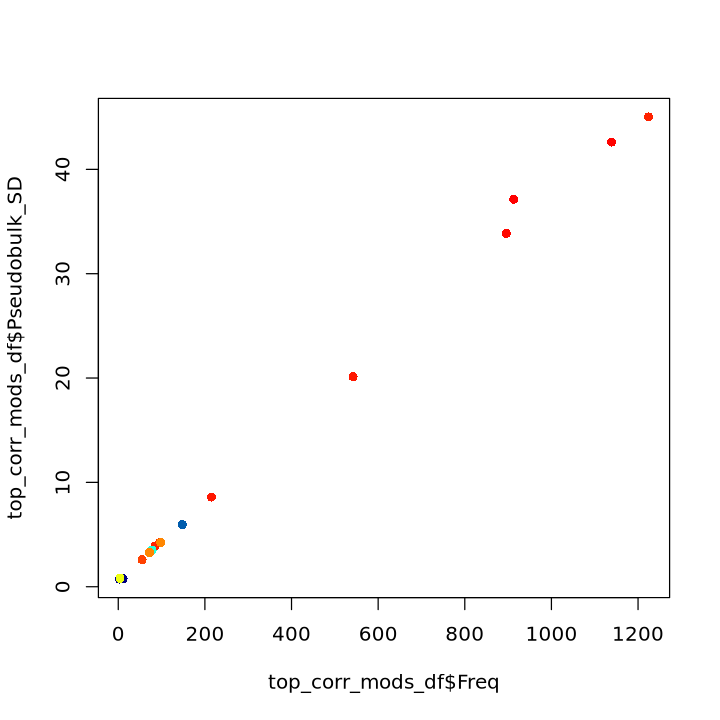

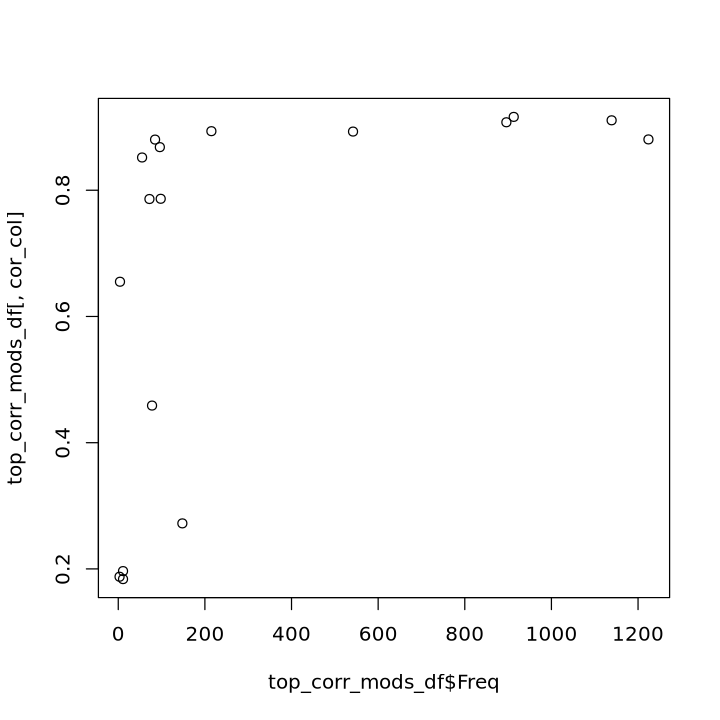

In [ ]:
plot_corr_vs_stats(cell_meta, top_corr_mods_40pcnt_PosBC_df)